# **Edmonton Food Drive 2024 - EDA**

## **Introduction**
The Edmonton Food Drive is a collaborative initiative designed to tackle food insecurity in Edmonton. This drive ​mobilizes volunteers and resources to collect and distribute food to those in need. By leveraging machine learning, ​the project aims to enhance operational efficiency and maximize the impact of each donation. The integration of ​real-time data and optimized routing will contribute to a more streamlined and effective food distribution process.

**Team Name:** Team 404

**Team Members:**
*   Catrina Llamas
*   Roe Joshua Alincastre
*   Kendrick Moreno

#### **Task 1: Imports and data loading**
Now lets import required libraries that we are going to use throughout this project.

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import sys
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import jinja2
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from utils.open_config import load_config
from preprocess import DataLoader, DataCleaner, DataMerger

##### **Load the dataset**
We are going to load the cleaned dataset.

In [2]:
params, project_root = load_config()
base_path = project_root
df_efd_cleaned = pd.read_csv(os.path.join(base_path, params["files"]["cleaned_data"]))
df_efd_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1045 non-null   int64  
 1   Drop Off Location        1045 non-null   object 
 2   Stake                    1045 non-null   object 
 3   Route Information        1045 non-null   object 
 4   Time Spent               1045 non-null   int64  
 5   Total Adult Volunteers   1045 non-null   float64
 6   Total Youth Volunteers   1045 non-null   float64
 7   Number of Doors          1045 non-null   float64
 8   Number of Donation Bags  1045 non-null   float64
 9   Number of Routes         1045 non-null   float64
 10  Ward                     1045 non-null   object 
 11  Year                     1045 non-null   int64  
 12  Latitude                 1041 non-null   float64
 13  Longitude                1041 non-null   float64
dtypes: float64(7), int64(3),

##### **Categorical Variables**
**Drop Off Location**

Lets visualize the frequency of different drop-off locations.

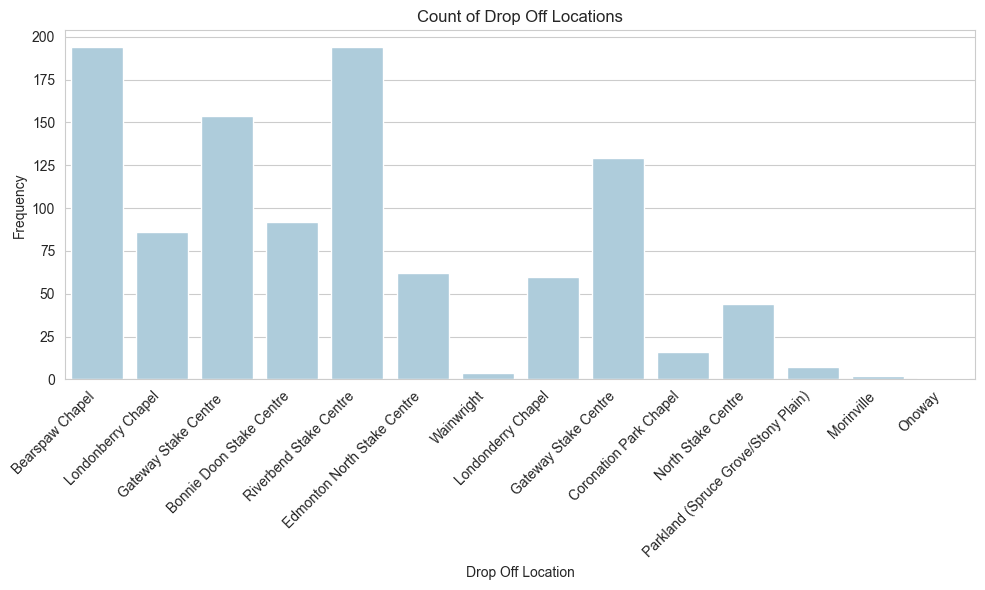

In [3]:
sns.set_palette("Paired")
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.countplot(data=df_efd_cleaned, x='Drop Off Location')
plt.title('Count of Drop Off Locations')
plt.xlabel('Drop Off Location')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Let's also examine the distribution of drop-off locations in terms of proportions.

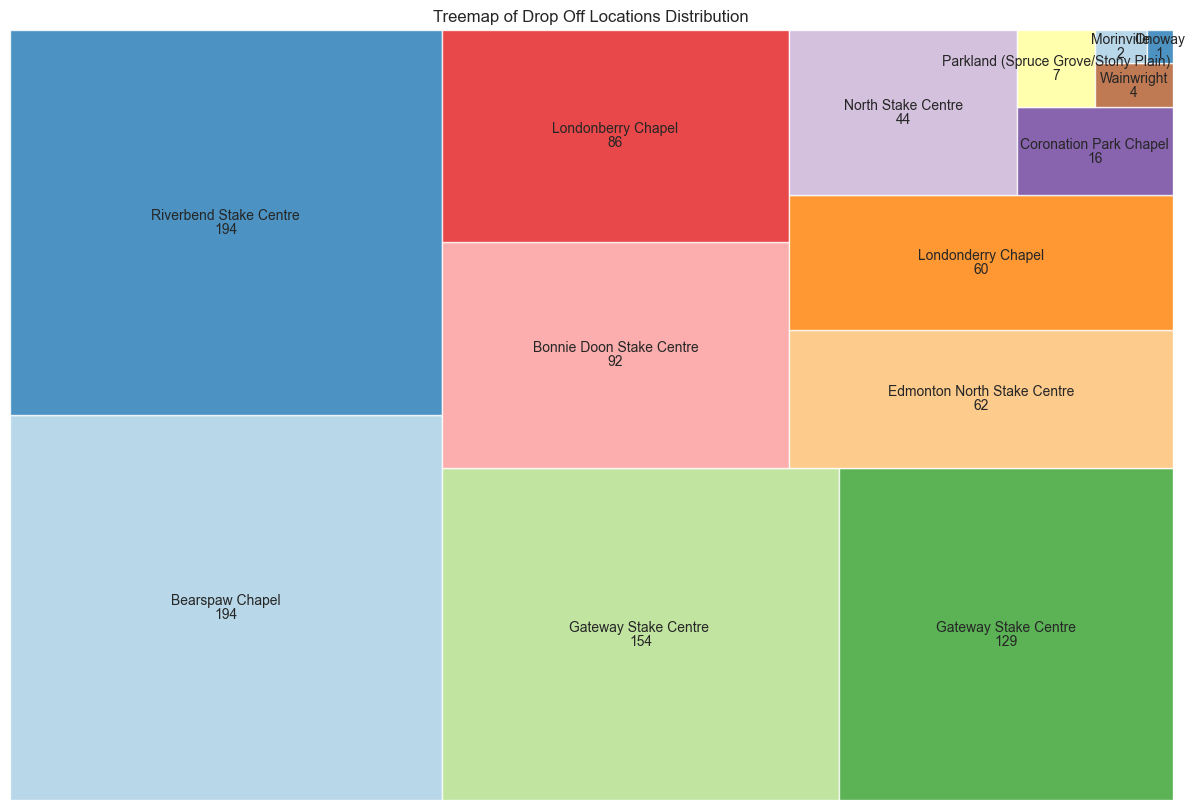

In [4]:
location_counts = df_efd_cleaned['Drop Off Location'].value_counts()

plt.figure(figsize=(15,10))
squarify.plot(sizes=location_counts.values,
              label=location_counts.index,
              value=location_counts.values,
              alpha=0.8,
              color=sns.color_palette('Paired', len(location_counts)))

plt.title('Treemap of Drop Off Locations Distribution')
plt.axis('off')
plt.show()

Let's analyze the relationship between drop-off locations and other variables, such as the number of donation bags and the number of volunteers.

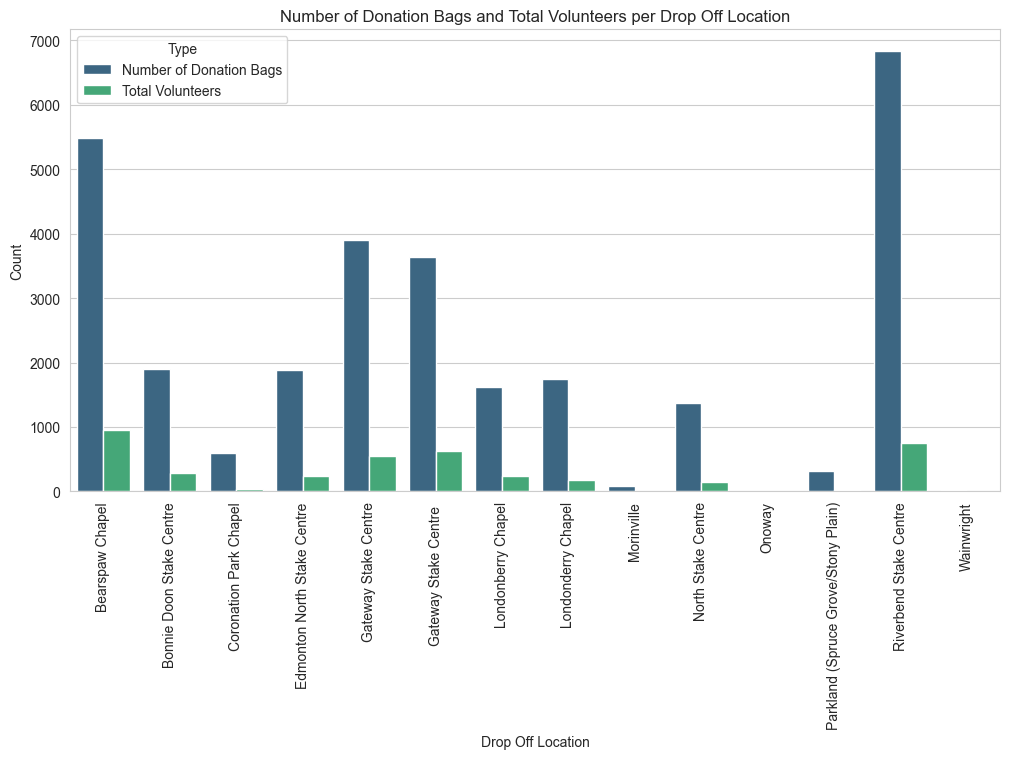

In [5]:
df_efd_cleaned['Total Volunteers'] = df_efd_cleaned['Total Adult Volunteers'] + df_efd_cleaned['Total Youth Volunteers']

grouped_data = df_efd_cleaned.groupby('Drop Off Location').agg({
    'Number of Donation Bags': 'sum',  # Replace with your actual column name for donation bags
    'Total Volunteers': 'sum'  # Using the new total volunteers column
}).reset_index()

melted_data = grouped_data.melt(id_vars='Drop Off Location',
                                 value_vars=['Number of Donation Bags', 'Total Volunteers'],
                                 var_name='Type',
                                 value_name='Count')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_data, x='Drop Off Location', y='Count', hue='Type', palette='viridis')
plt.title('Number of Donation Bags and Total Volunteers per Drop Off Location')
plt.xlabel('Drop Off Location')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Type')
plt.show()

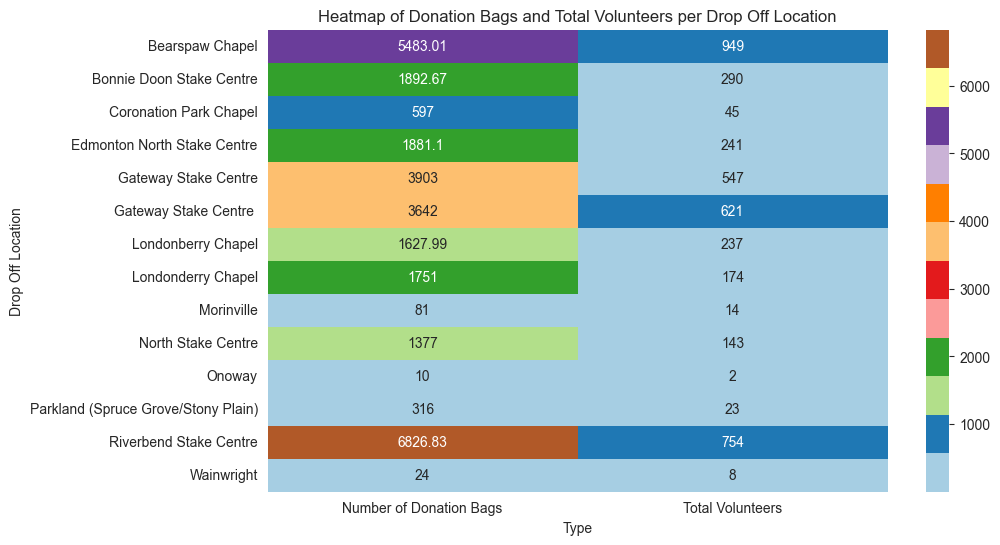

In [6]:
melted_data = grouped_data.melt(id_vars='Drop Off Location',
                                 value_vars=['Number of Donation Bags', 'Total Volunteers'],
                                 var_name='Type',
                                 value_name='Count')

pivot_data = melted_data.pivot_table(index='Drop Off Location',
                                      columns='Type',
                                      values='Count',
                                      fill_value=0)  # Fill missing values with 0

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, cmap='Paired', fmt='g')
plt.title('Heatmap of Donation Bags and Total Volunteers per Drop Off Location')
plt.xlabel('Type')
plt.ylabel('Drop Off Location')
plt.show()

**Stake**

Let's count the occurrences of each Stake.

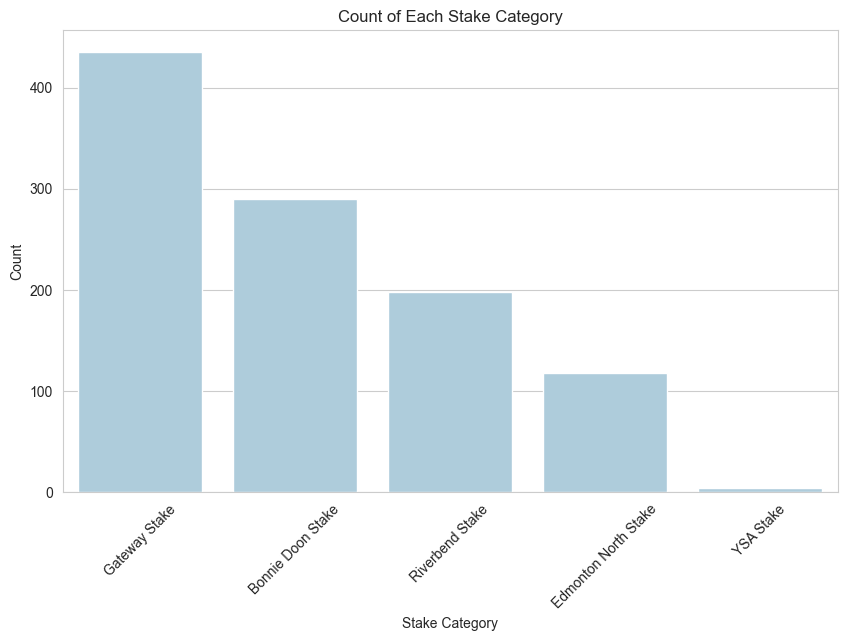

In [7]:
sns.set_palette('Paired')
plt.figure(figsize=(10, 6))
sns.countplot(data=df_efd_cleaned, x='Stake', order=df_efd_cleaned['Stake'].value_counts().index)
plt.title('Count of Each Stake Category')
plt.xlabel('Stake Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Let's analyze the impact of the Stake on other numerical features, such as the number of doors and the number of donation bags.

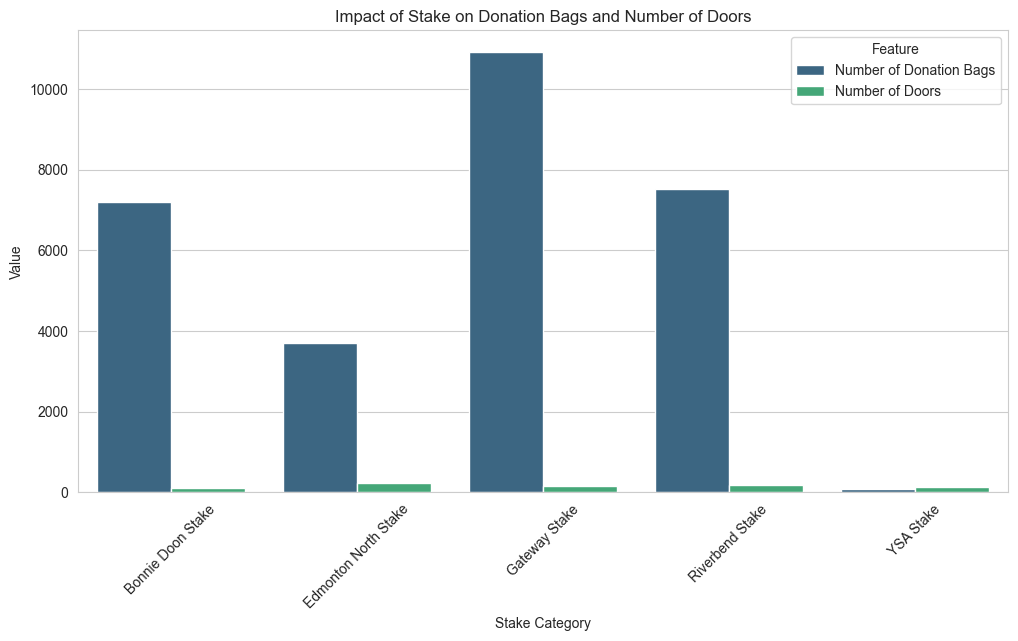

In [8]:
# @title
grouped_stake_data = df_efd_cleaned.groupby('Stake').agg({
    'Number of Donation Bags': 'sum',
    'Number of Doors': 'mean'
}).reset_index()

melted_stake_data = grouped_stake_data.melt(id_vars='Stake',
                                              value_vars=['Number of Donation Bags', 'Number of Doors'],
                                              var_name='Feature',
                                              value_name='Value')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_stake_data, x='Stake', y='Value', hue='Feature', palette='viridis')
plt.title('Impact of Stake on Donation Bags and Number of Doors')
plt.xlabel('Stake Category')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Feature')
plt.show()

**Time Spent**

Lets visualize how often each time category appears.

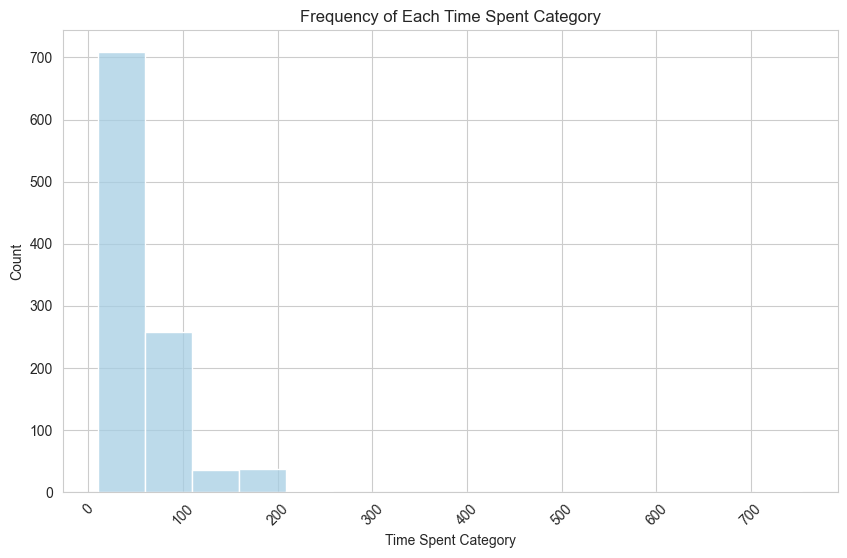

In [9]:
sns.set_palette('Paired')
plt.figure(figsize=(10, 6))
sns.histplot(data=df_efd_cleaned, x='Time Spent', bins=15, kde=False)
plt.title('Frequency of Each Time Spent Category')
plt.xlabel('Time Spent Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Let's explore the distribution of time spent for each Stake.

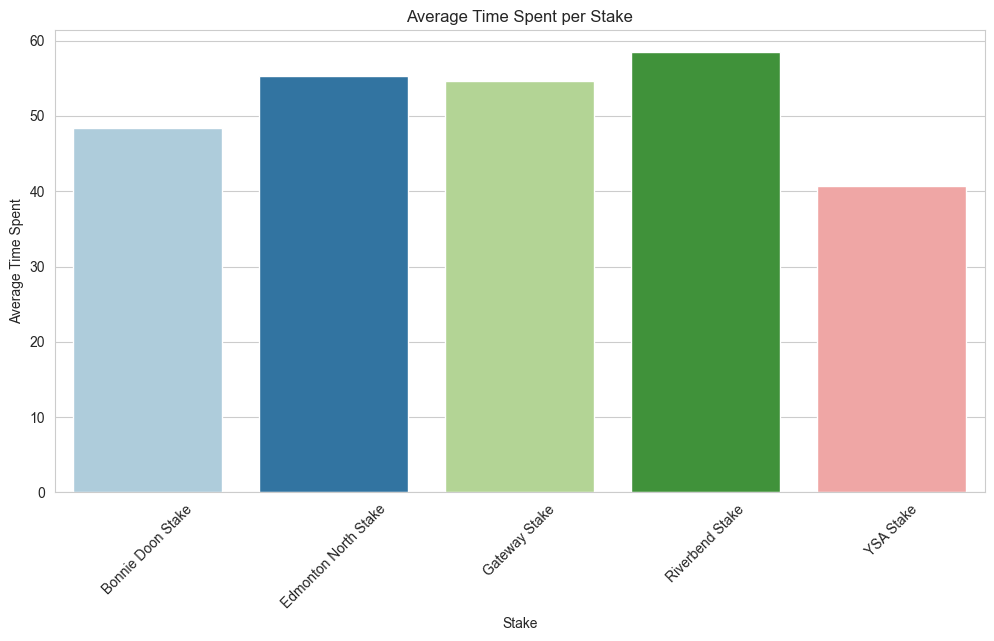

In [10]:
plt.figure(figsize=(12, 6))
average_time_spent = df_efd_cleaned.groupby('Stake')['Time Spent'].mean().reset_index()
sns.barplot(data=average_time_spent, x='Stake', y='Time Spent', palette='Paired')
plt.title('Average Time Spent per Stake')
plt.xlabel('Stake')
plt.ylabel('Average Time Spent')
plt.xticks(rotation=45)
plt.show()

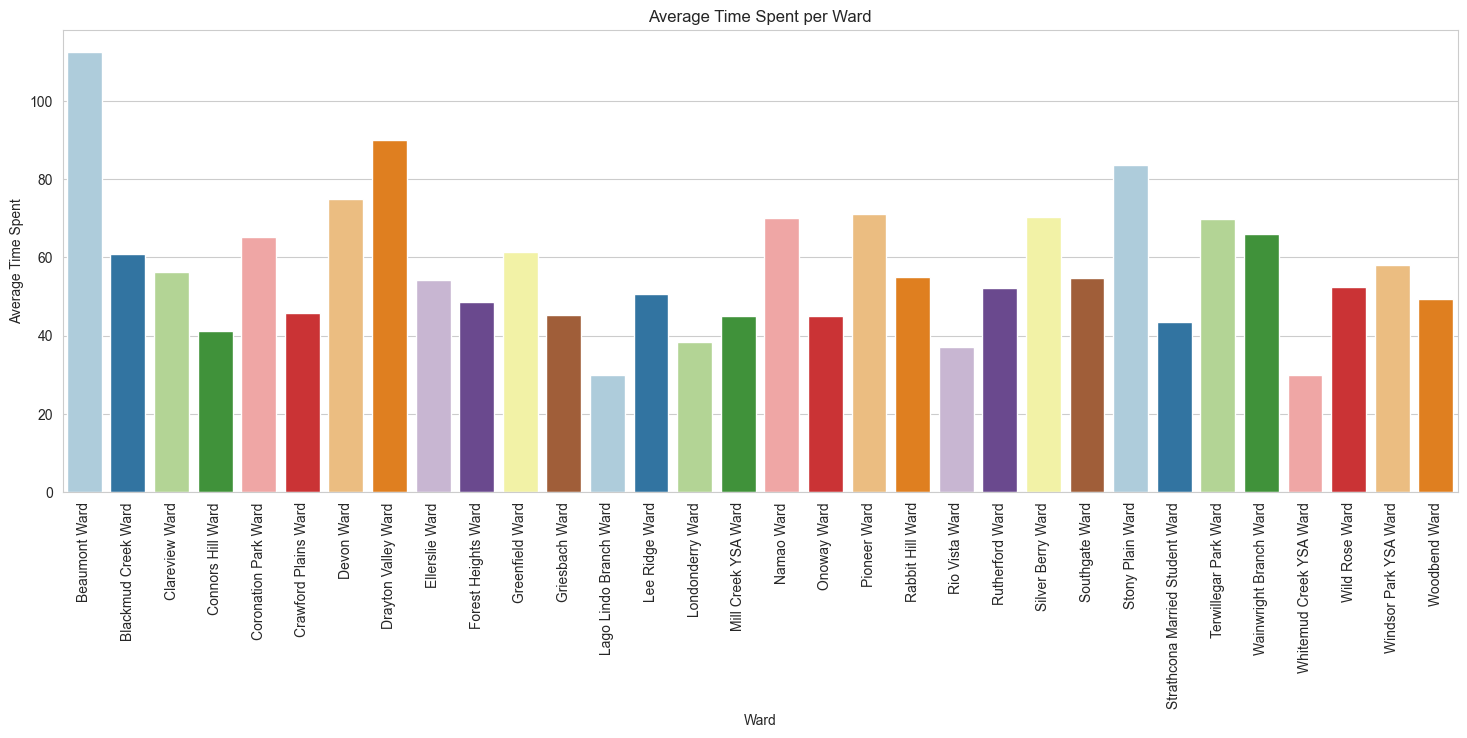

In [11]:
plt.figure(figsize=(18, 6))
average_time_spent_per_ward = df_efd_cleaned.groupby('Ward')['Time Spent'].mean().reset_index()
sns.barplot(data=average_time_spent_per_ward, x='Ward', y='Time Spent', palette='Paired')
plt.title('Average Time Spent per Ward')
plt.xlabel('Ward')
plt.ylabel('Average Time Spent')
plt.xticks(rotation=90)
plt.show()

**Ward**

Let's visualize the distribution across different Wards.

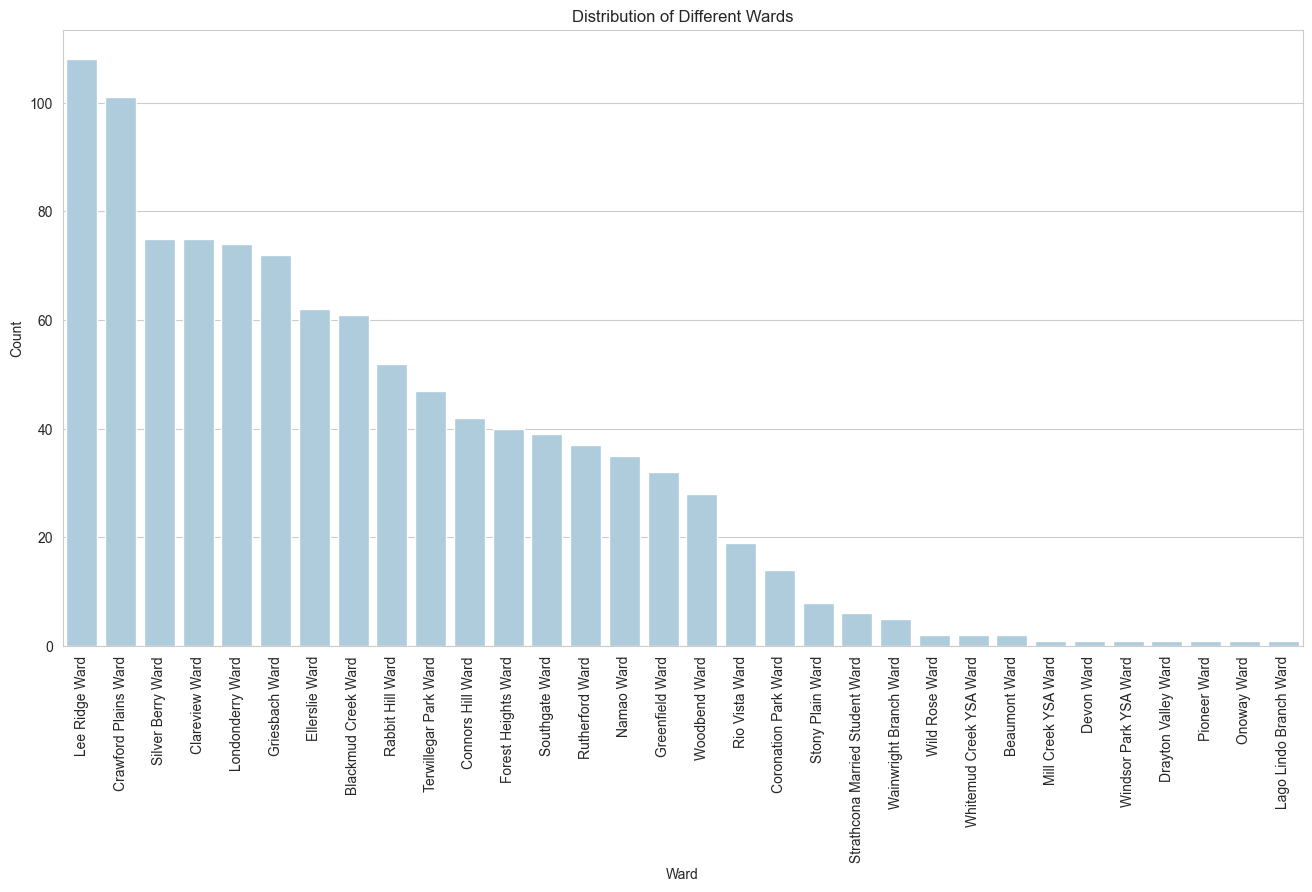

In [12]:
sns.set_palette('Paired')
plt.figure(figsize=(16, 8))
sns.countplot(data=df_efd_cleaned, x='Ward', order=df_efd_cleaned['Ward'].value_counts().index)
plt.title('Distribution of Different Wards')
plt.xlabel('Ward')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

Let's analyze how the Ward influences other variables, such as the number of donation bags and routes.

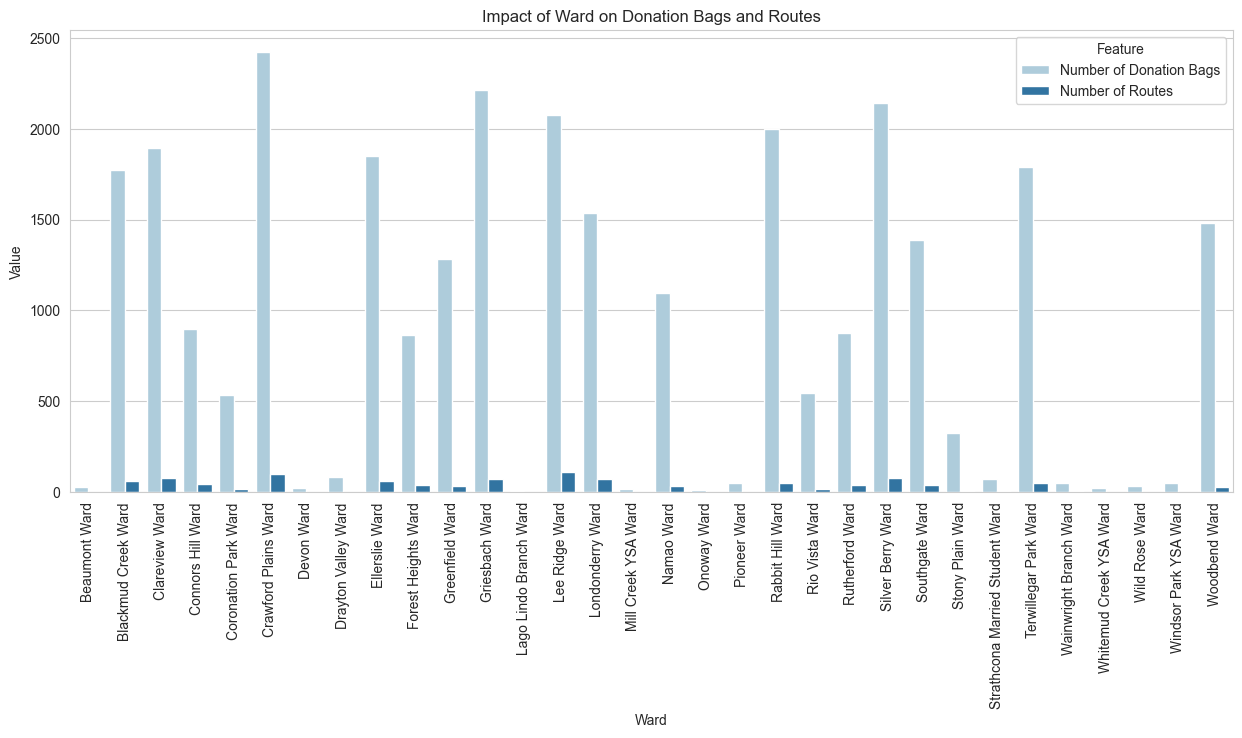

In [13]:
grouped_ward_data = df_efd_cleaned.groupby('Ward').agg({
    'Number of Donation Bags': 'sum',
    'Number of Routes': 'count'
}).reset_index()

melted_ward_data = grouped_ward_data.melt(id_vars='Ward',
                                            value_vars=['Number of Donation Bags', 'Number of Routes'],
                                            var_name='Feature',
                                            value_name='Value')

plt.figure(figsize=(15, 6))
sns.barplot(data=melted_ward_data, x='Ward', y='Value', hue='Feature', palette='Paired')
plt.title('Impact of Ward on Donation Bags and Routes')
plt.xlabel('Ward')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.legend(title='Feature')
plt.show()

##### **Numerical Variables**
**Total Volunteers**
Let's examine the distribution of volunteers.

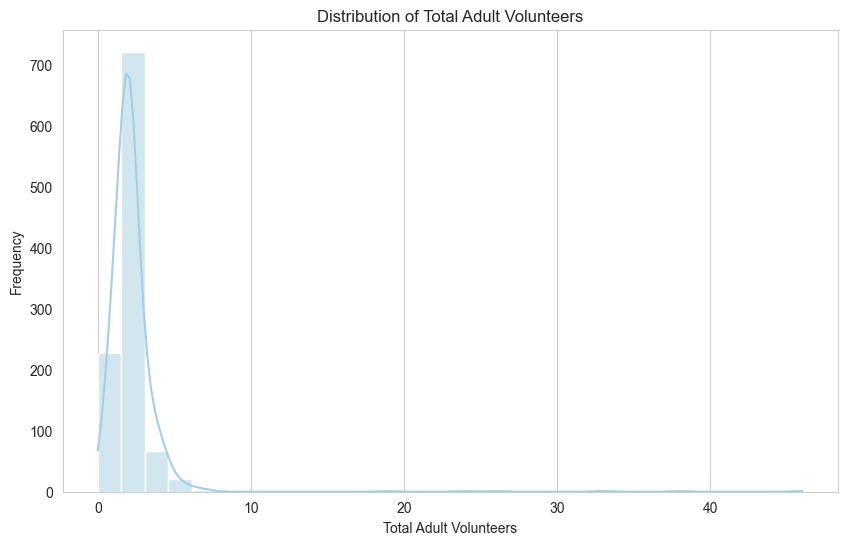

In [14]:
sns.set_palette('Paired')
plt.figure(figsize=(10, 6))
sns.histplot(df_efd_cleaned['Total Adult Volunteers'], bins=30, kde=True)
plt.title('Distribution of Total Adult Volunteers')
plt.xlabel('Total Adult Volunteers')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Let's analyze the correlation between adult volunteers and other numerical features.

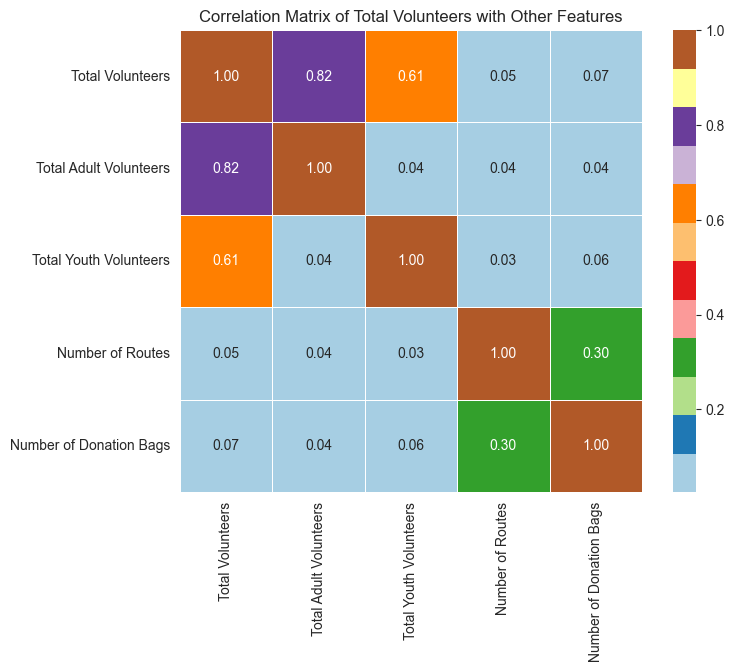

In [15]:
correlation_matrix = df_efd_cleaned[['Total Volunteers', 'Total Adult Volunteers', 'Total Youth Volunteers', 'Number of Routes', 'Number of Donation Bags']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Paired', fmt='.2f', square=True, linewidths=.5)
plt.title('Correlation Matrix of Total Volunteers with Other Features')
plt.show()

**Number of Doors**

Let's visualize the distribution of the number of doors.

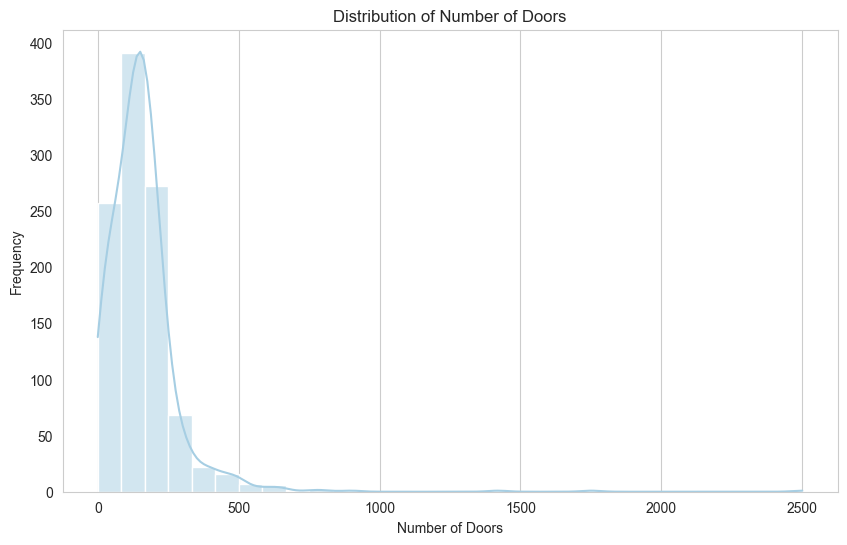

In [16]:
sns.set_palette('Paired')
plt.figure(figsize=(10, 6))
sns.histplot(df_efd_cleaned['Number of Doors'], bins=30, kde=True)
plt.title('Distribution of Number of Doors')
plt.xlabel('Number of Doors')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Let's examine the relationship between the number of doors and other categorical variables.

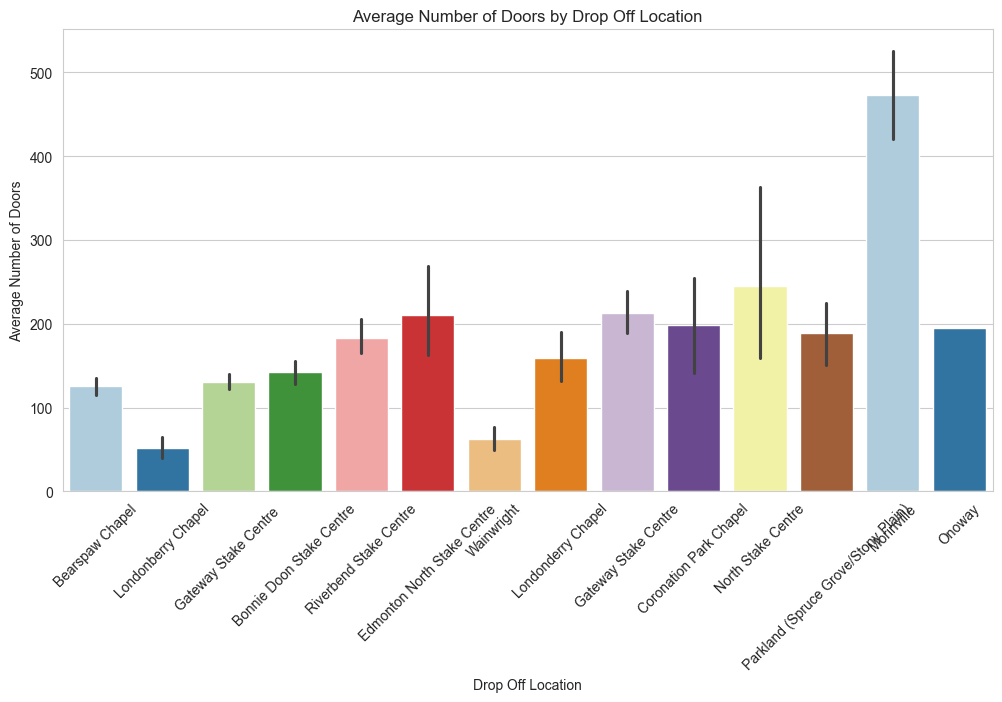

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_efd_cleaned, x='Drop Off Location', y='Number of Doors', estimator='mean', palette='Paired')
plt.title('Average Number of Doors by Drop Off Location')
plt.xlabel('Drop Off Location')
plt.ylabel('Average Number of Doors')
plt.xticks(rotation=45)
plt.show()

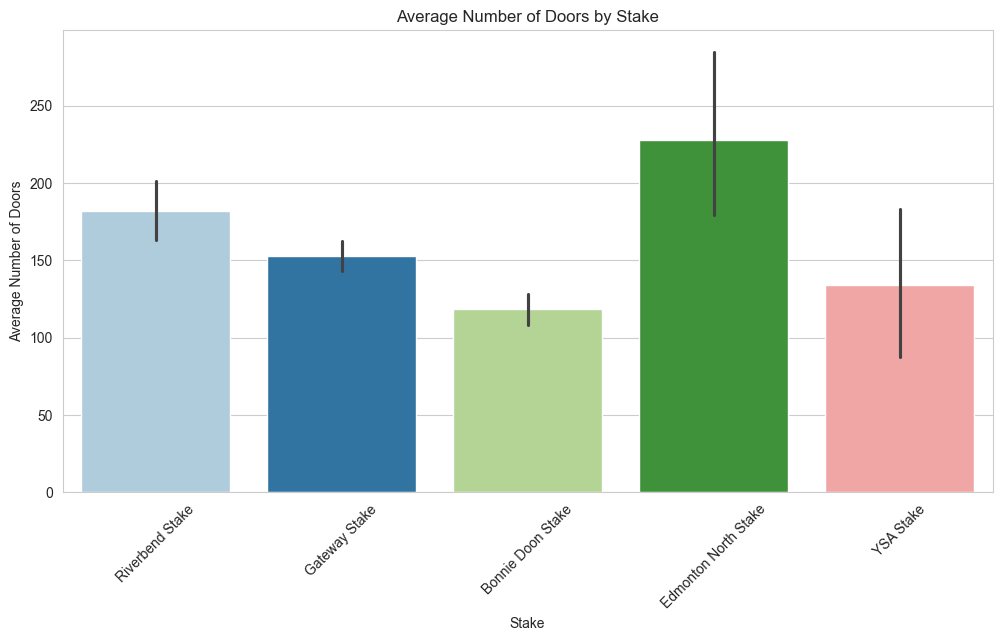

In [18]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_efd_cleaned, x='Stake', y='Number of Doors', estimator='mean', palette='Paired')
plt.title('Average Number of Doors by Stake')
plt.xlabel('Stake')
plt.ylabel('Average Number of Doors')
plt.xticks(rotation=45)
plt.show()

**Number of Donation Bags**

Let's explore the relationships with other numerical variables.

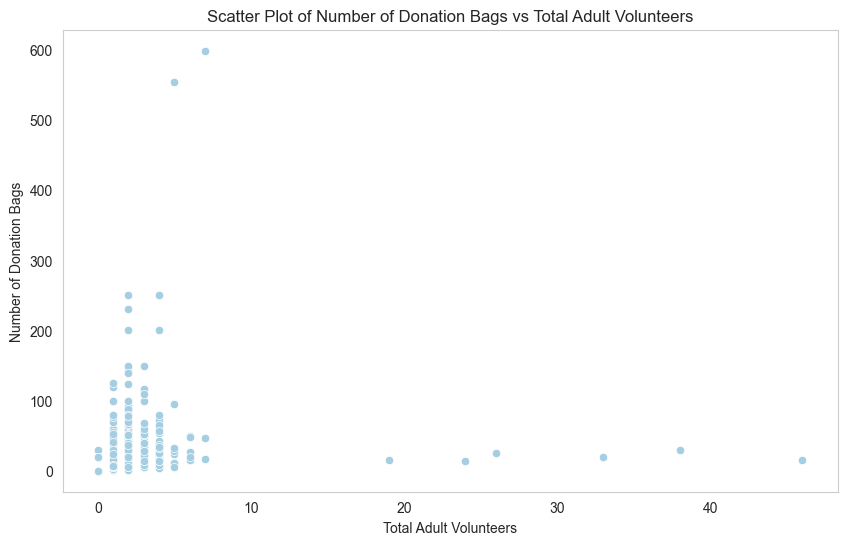

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_efd_cleaned, x='Total Adult Volunteers', y='Number of Donation Bags', palette='Paired')
plt.title('Scatter Plot of Number of Donation Bags vs Total Adult Volunteers')
plt.xlabel('Total Adult Volunteers')
plt.ylabel('Number of Donation Bags')
plt.grid()
plt.show()

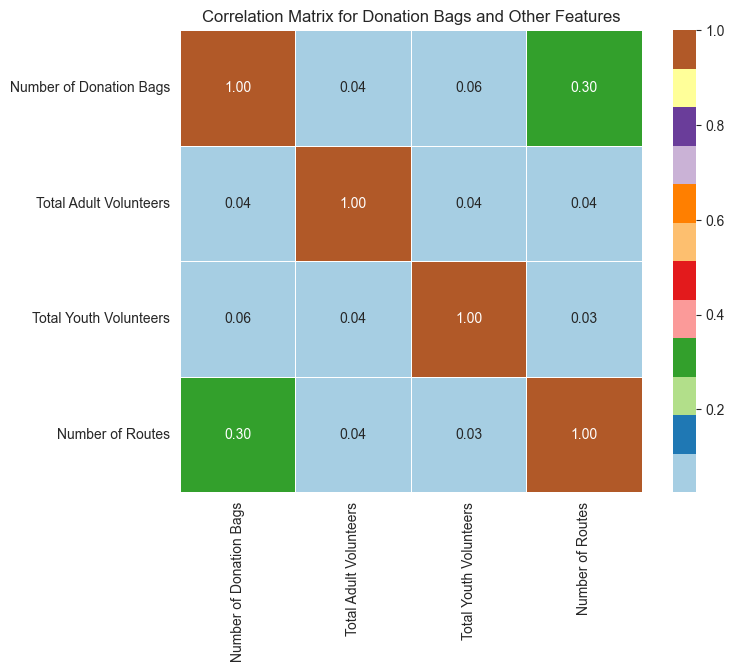

In [20]:
correlation_matrix = df_efd_cleaned[['Number of Donation Bags', 'Total Adult Volunteers', 'Total Youth Volunteers', 'Number of Routes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Paired', fmt='.2f', square=True, linewidths=.5)
plt.title('Correlation Matrix for Donation Bags and Other Features')
plt.show()

Let's compare how the number of donation bags varies across different locations and Wards.

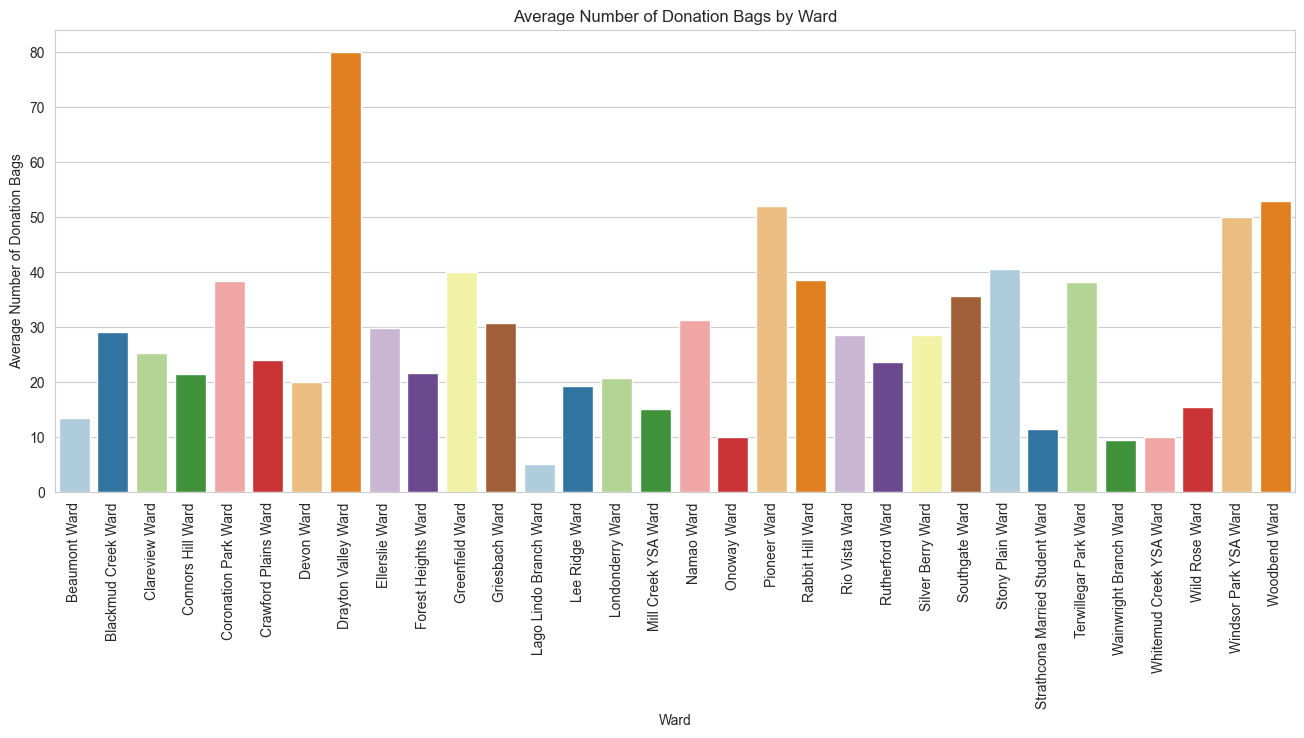

In [21]:
grouped_by_ward = df_efd_cleaned.groupby('Ward')['Number of Donation Bags'].mean().reset_index()
plt.figure(figsize=(16, 6))
sns.barplot(data=grouped_by_ward, x='Ward', y='Number of Donation Bags', palette='Paired')
plt.title('Average Number of Donation Bags by Ward')
plt.xlabel('Ward')
plt.ylabel('Average Number of Donation Bags')
plt.xticks(rotation=90)
plt.show()

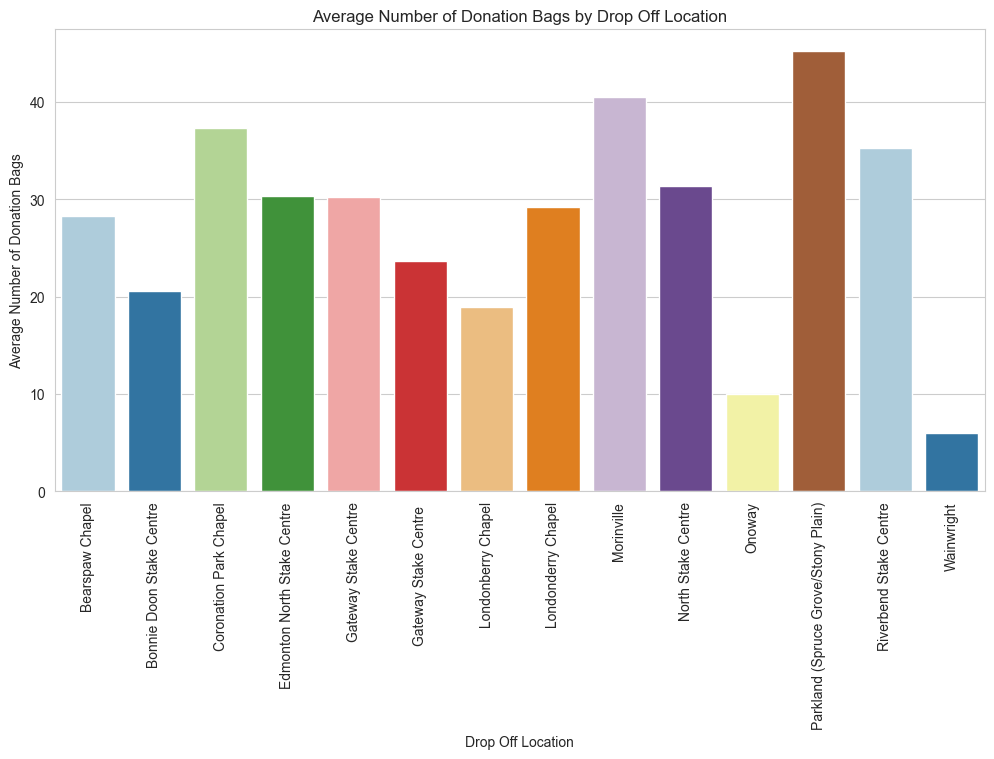

In [22]:
grouped_by_drop_off = df_efd_cleaned.groupby('Drop Off Location')['Number of Donation Bags'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_by_drop_off, x='Drop Off Location', y='Number of Donation Bags', palette='Paired')
plt.title('Average Number of Donation Bags by Drop Off Location')
plt.xlabel('Drop Off Location')
plt.ylabel('Average Number of Donation Bags')
plt.xticks(rotation=90)
plt.show()

**Number of Routes**

Lets examine the distribution of the number of rooutes

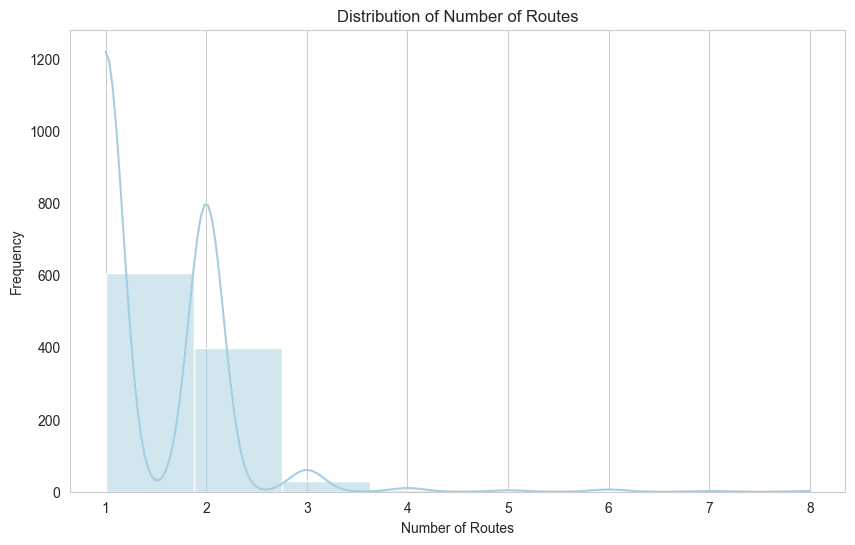

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df_efd_cleaned['Number of Routes'], bins=8, kde=True)
plt.title('Distribution of Number of Routes')
plt.xlabel('Number of Routes')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

Let's compare the number of donation bags to the number of routes.

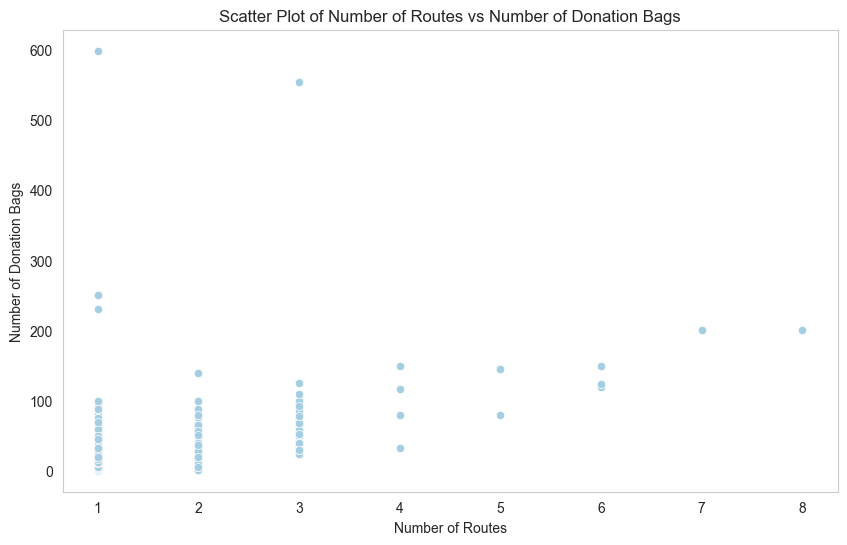

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_efd_cleaned, x='Number of Routes', y='Number of Donation Bags', palette='Paired')
plt.title('Scatter Plot of Number of Routes vs Number of Donation Bags')
plt.xlabel('Number of Routes')
plt.ylabel('Number of Donation Bags')
plt.grid()
plt.show()

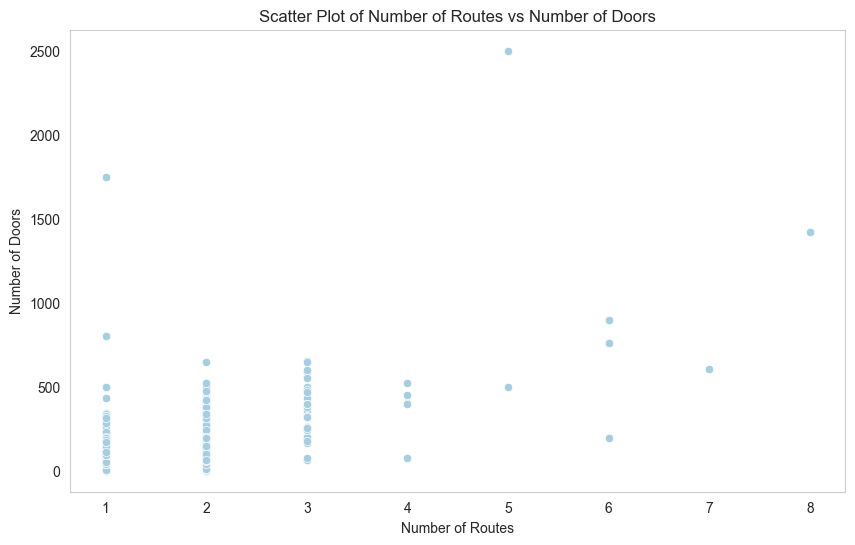

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_efd_cleaned, x='Number of Routes', y='Number of Doors', palette='Paired')
plt.title('Scatter Plot of Number of Routes vs Number of Doors')
plt.xlabel('Number of Routes')
plt.ylabel('Number of Doors')
plt.grid()
plt.show()

**Year**

Let's examine the trends over the years for the number of donation bags and total volunteers.

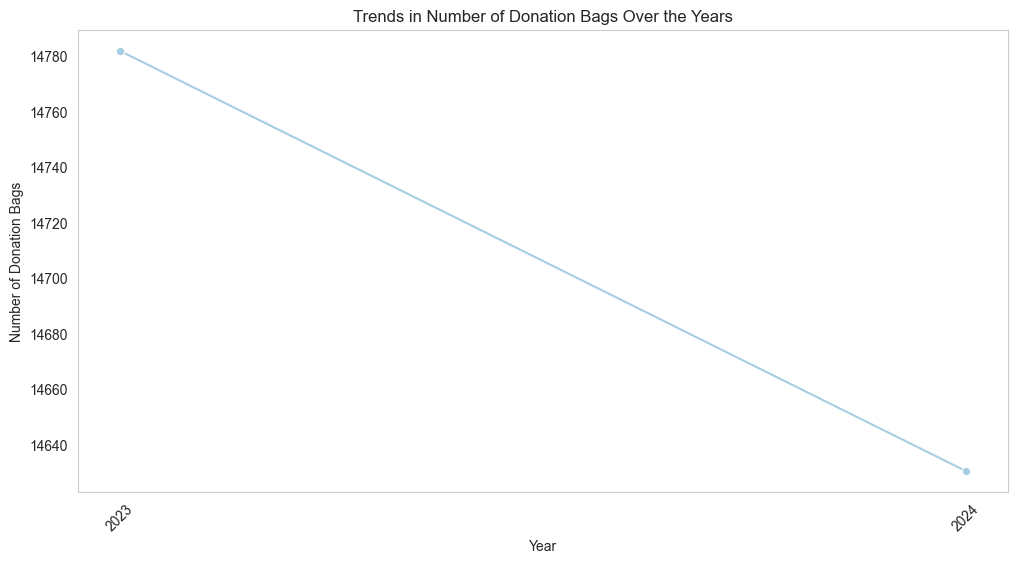

In [26]:
sns.set_palette('Paired')
yearly_donations = df_efd_cleaned.groupby('Year')['Number of Donation Bags'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_donations, x='Year', y='Number of Donation Bags', marker='o')
plt.title('Trends in Number of Donation Bags Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Donation Bags')
plt.grid()
plt.xticks(yearly_donations['Year'], rotation=45)
plt.show()

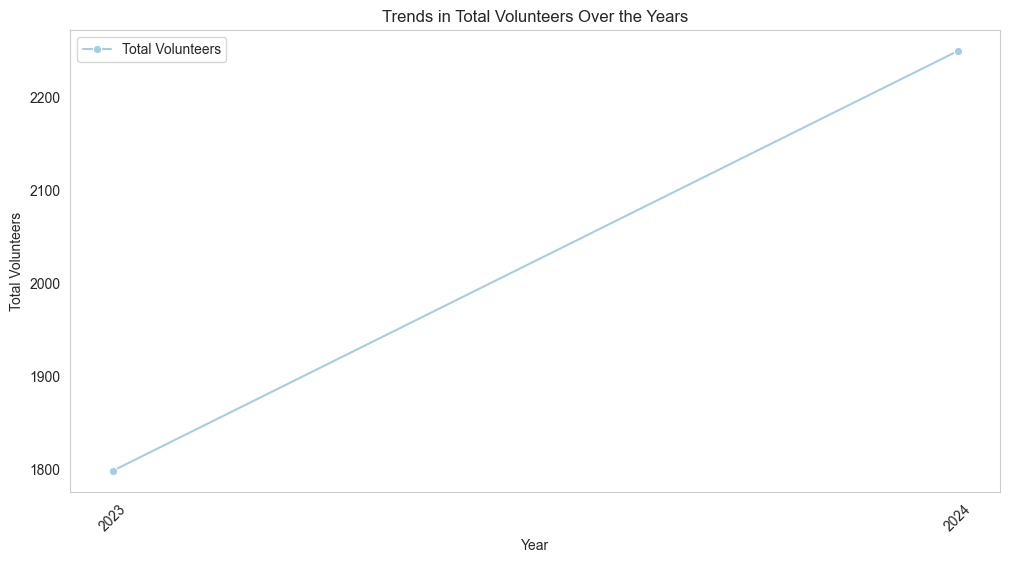

In [27]:
yearly_volunteers = df_efd_cleaned.groupby('Year')[['Total Adult Volunteers', 'Total Youth Volunteers']].sum().reset_index()
yearly_volunteers['Total Volunteers'] = yearly_volunteers['Total Adult Volunteers'] + yearly_volunteers['Total Youth Volunteers']
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_volunteers, x='Year', y='Total Volunteers', marker='o', label='Total Volunteers')
plt.title('Trends in Total Volunteers Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Volunteers')
plt.grid()
plt.xticks(yearly_volunteers['Year'], rotation=45)
plt.legend()
plt.show()

Let's analyze how the numerical features have changed over the years.

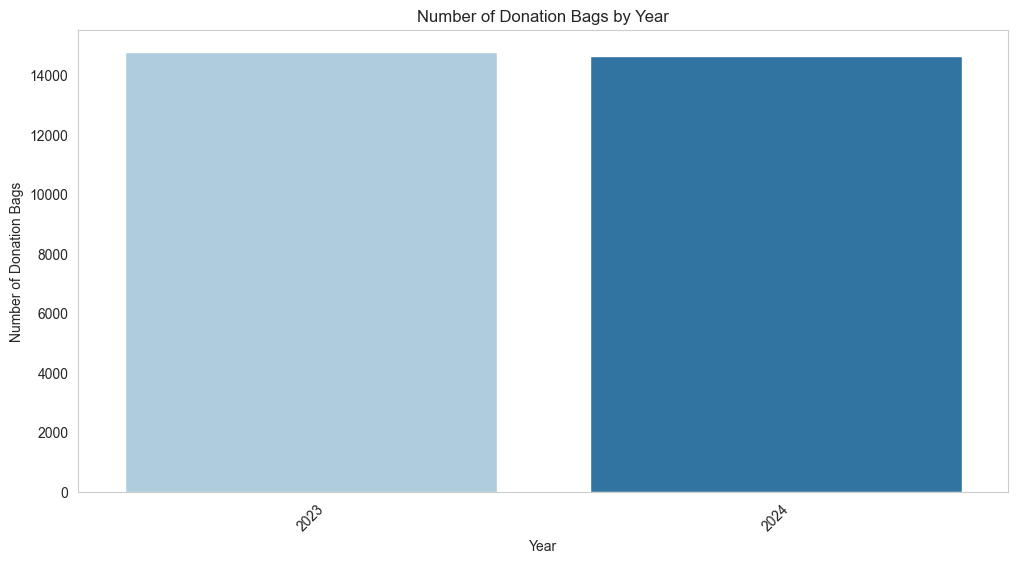

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_donations, x='Year', y='Number of Donation Bags', palette='Paired')
plt.title('Number of Donation Bags by Year')
plt.xlabel('Year')
plt.ylabel('Number of Donation Bags')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

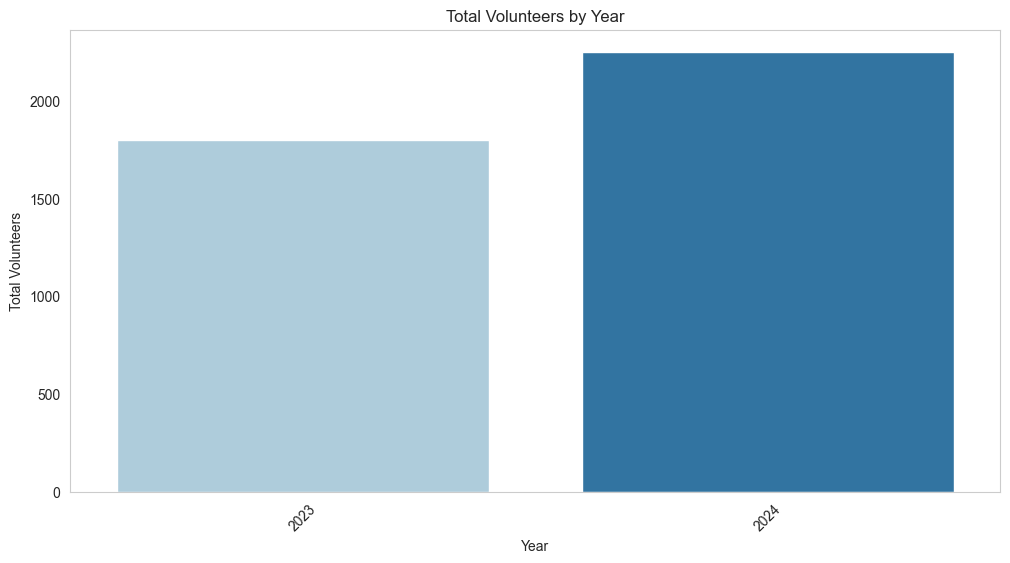

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(data=yearly_volunteers, x='Year', y='Total Volunteers', palette='Paired')
plt.title('Total Volunteers by Year')
plt.xlabel('Year')
plt.ylabel('Total Volunteers')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

##### **Key Insights**
**2023 vs 2024**
Now lets check the percentage of Increase or Decrease of each variables per year.

In [30]:
comparison_years = df_efd_cleaned[df_efd_cleaned['Year'].isin([2023, 2024])]
comparison_data = comparison_years.groupby('Year').agg({
    'Total Adult Volunteers': 'sum',
    'Total Youth Volunteers': 'sum',
    'Number of Donation Bags': 'sum',
    'Number of Routes': 'sum',
    'Time Spent': 'sum',
    'Number of Doors': 'sum'
}).reset_index()

comparison_data['Total Volunteers'] = comparison_data['Total Adult Volunteers'] + comparison_data['Total Youth Volunteers']
percentage_change = comparison_data.set_index('Year').diff().iloc[-1] / comparison_data.set_index('Year').iloc[0] * 100
percentage_change_df = percentage_change.reset_index()
percentage_change_df.columns = ['Metrics', 'Percentage Change']
percentage_change_df

,Metrics,Percentage Change
0,Total Adult Volunteers,17.032967
1,Total Youth Volunteers,37.677054
2,Number of Donation Bags,-1.024174
3,Number of Routes,-38.229167
4,Time Spent,-30.812393
5,Number of Doors,-14.445504
6,Total Volunteers,25.139043


Let's take a closer look at the Stake.

In [31]:
stake_comparison_data = comparison_years.groupby(['Year', 'Stake']).agg({
    'Total Adult Volunteers': 'sum',
    'Total Youth Volunteers': 'sum',
    'Number of Donation Bags': 'sum',
    'Number of Routes': 'sum',
    'Time Spent': 'sum',
    'Number of Doors': 'sum'
}).reset_index()

stake_comparison_data['Total Volunteers'] = stake_comparison_data['Total Adult Volunteers'] + stake_comparison_data['Total Youth Volunteers']
stake_expanded_df = stake_comparison_data.pivot(index='Stake', columns='Year',
                                                values=['Total Adult Volunteers',
                                                        'Total Youth Volunteers',
                                                        'Number of Donation Bags',
                                                        'Number of Routes',
                                                        'Time Spent',
                                                        'Number of Doors',
                                                        'Total Volunteers'])

stake_expanded_df.columns = [' '.join(map(str, col)).strip() for col in stake_expanded_df.columns.values]
stake_expanded_df.reset_index(inplace=True)
metrics = ['Total Adult Volunteers', 'Total Youth Volunteers',
           'Number of Donation Bags', 'Number of Routes',
           'Time Spent', 'Number of Doors',
           'Total Volunteers']

difference_data = {'Stake': stake_expanded_df['Stake']}

for metric in metrics:
    difference_data[f'{metric} Difference'] = stake_expanded_df[f'{metric} 2024'] - stake_expanded_df[f'{metric} 2023']

difference_df = pd.DataFrame(difference_data)
difference_df

,Stake,Total Adult Volunteers Difference,Total Youth Volunteers Difference,Number of Donation Bags Difference,Number of Routes Difference,Time Spent Difference,Number of Doors Difference,Total Volunteers Difference
0,Bonnie Doon Stake,42.0,9.0,-965.326667,-111.0,-2393.0,-5781.326667,51.0
1,Edmonton North Stake,44.0,5.0,1.100000,-66.0,-2147.0,-1205.333333,49.0
2,Gateway Stake,-29.0,140.0,-52.000000,-154.0,-5999.0,-8816.333333,111.0
3,Riverbend Stake,124.0,114.0,879.833333,-37.0,278.0,2696.666667,238.0
4,YSA Stake,5.0,-2.0,-15.000000,1.0,47.0,317.000000,3.0


Now lets check for Wards.

In [32]:
ward_comparison_data = comparison_years.groupby(['Year', 'Ward']).agg({
    'Total Adult Volunteers': 'sum',
    'Total Youth Volunteers': 'sum',
    'Number of Donation Bags': 'sum',
    'Number of Routes': 'sum',
    'Time Spent': 'sum',
    'Number of Doors': 'sum'
}).reset_index()

ward_comparison_data['Total Volunteers'] = ward_comparison_data['Total Adult Volunteers'] + ward_comparison_data['Total Youth Volunteers']
ward_expanded_df = ward_comparison_data.pivot(index='Ward', columns='Year',
                                              values=['Total Adult Volunteers',
                                                      'Total Youth Volunteers',
                                                      'Number of Donation Bags',
                                                      'Number of Routes',
                                                      'Time Spent',
                                                      'Number of Doors',
                                                      'Total Volunteers'])

ward_expanded_df.columns = [' '.join(map(str, col)).strip() for col in ward_expanded_df.columns.values]
ward_expanded_df.reset_index(inplace=True)
metrics = ['Total Adult Volunteers', 'Total Youth Volunteers',
           'Number of Donation Bags', 'Number of Routes',
           'Time Spent', 'Number of Doors',
           'Total Volunteers']

difference_data = {'Ward': ward_expanded_df['Ward']}

for metric in metrics:
    difference_data[f'{metric} Difference'] = ward_expanded_df[f'{metric} 2024'] - ward_expanded_df[f'{metric} 2023']

difference_df = pd.DataFrame(difference_data)
difference_df

,Ward,Total Adult Volunteers Difference,Total Youth Volunteers Difference,Number of Donation Bags Difference,Number of Routes Difference,Time Spent Difference,Number of Doors Difference,Total Volunteers Difference
0,Beaumont Ward,-1.0,-2.0,-13.000000,-1.0,-135.0,-135.000000,-3.0
1,Blackmud Creek Ward,-34.0,-17.0,188.000000,-26.0,-556.0,-389.000000,-51.0
2,Clareview Ward,30.0,5.0,-74.010000,-18.0,-894.0,-1908.000000,35.0
3,Connors Hill Ward,41.0,26.0,349.673333,9.0,526.0,1968.673333,67.0
4,Coronation Park Ward,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Crawford Plains Ward,34.0,46.0,-161.500000,-42.0,-731.0,-2095.000000,80.0
6,Devon Ward,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Drayton Valley Ward,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Ellerslie Ward,-27.0,6.0,-68.500000,-30.0,-1590.0,-2822.000000,-21.0
9,Forest Heights Ward,-3.0,-5.0,-48.000000,-20.0,-351.0,398.000000,-8.0


**Top 3 Stakes in all categories.**

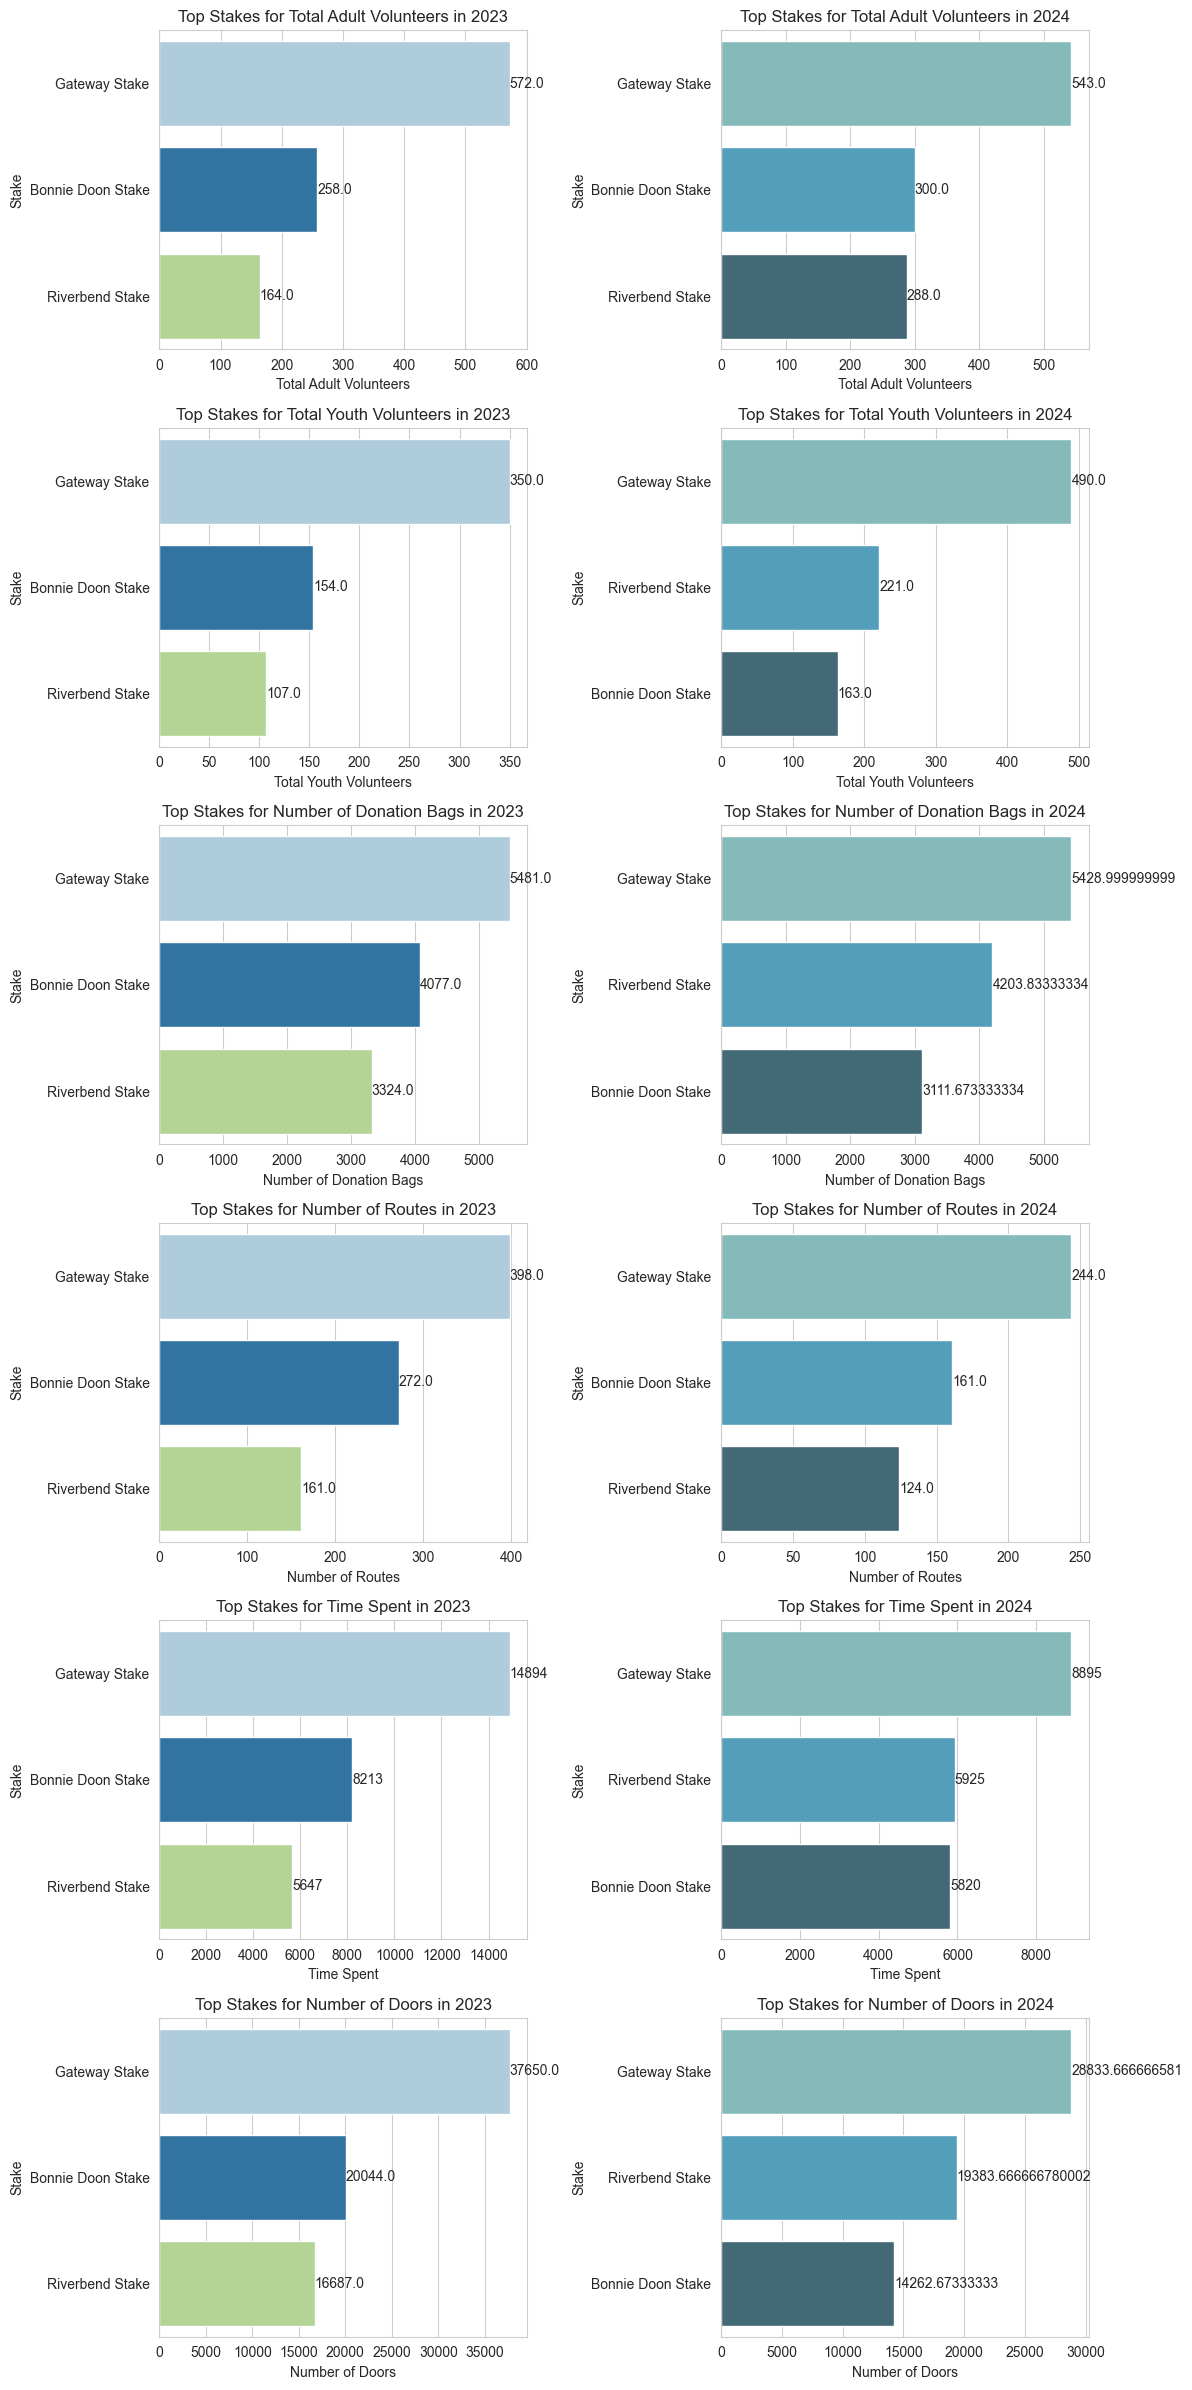

In [33]:
metrics = [
    'Total Adult Volunteers',
    'Total Youth Volunteers',
    'Number of Donation Bags',
    'Number of Routes',
    'Time Spent',
    'Number of Doors'
]

stake_totals = df_efd_cleaned.groupby(['Stake', 'Year'])[metrics].sum().reset_index()

n_metrics = len(metrics)
fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, n_metrics * 4))

for i, metric in enumerate(metrics):
    top_3_stakes_2023 = stake_totals[stake_totals['Year'] == 2023].nlargest(3, metric)
    top_3_stakes_2024 = stake_totals[stake_totals['Year'] == 2024].nlargest(3, metric)

    top_3_stakes_2023_sorted = top_3_stakes_2023.sort_values(by=metric, ascending=False)
    top_3_stakes_2024_sorted = top_3_stakes_2024.sort_values(by=metric, ascending=False)

    sns.barplot(x=metric, y='Stake', data=top_3_stakes_2023_sorted, ax=axes[i][0], palette='Paired', order=top_3_stakes_2023_sorted['Stake'])
    axes[i][0].set_title(f'Top Stakes for {metric} in 2023')
    axes[i][0].set_xlabel(metric)
    axes[i][0].set_ylabel('Stake')

    for index, value in enumerate(top_3_stakes_2023_sorted[metric]):
        axes[i][0].text(value, index, f'{value}', va='center')

    sns.barplot(x=metric, y='Stake', data=top_3_stakes_2024_sorted, ax=axes[i][1], palette='GnBu_d', order=top_3_stakes_2024_sorted['Stake'])
    axes[i][1].set_title(f'Top Stakes for {metric} in 2024')
    axes[i][1].set_xlabel(metric)
    axes[i][1].set_ylabel('Stake')

    for index, value in enumerate(top_3_stakes_2024_sorted[metric]):
        axes[i][1].text(value, index, f'{value}', va='center')

plt.tight_layout()
plt.show()

**Bottom 3 Stakes in all categories.**

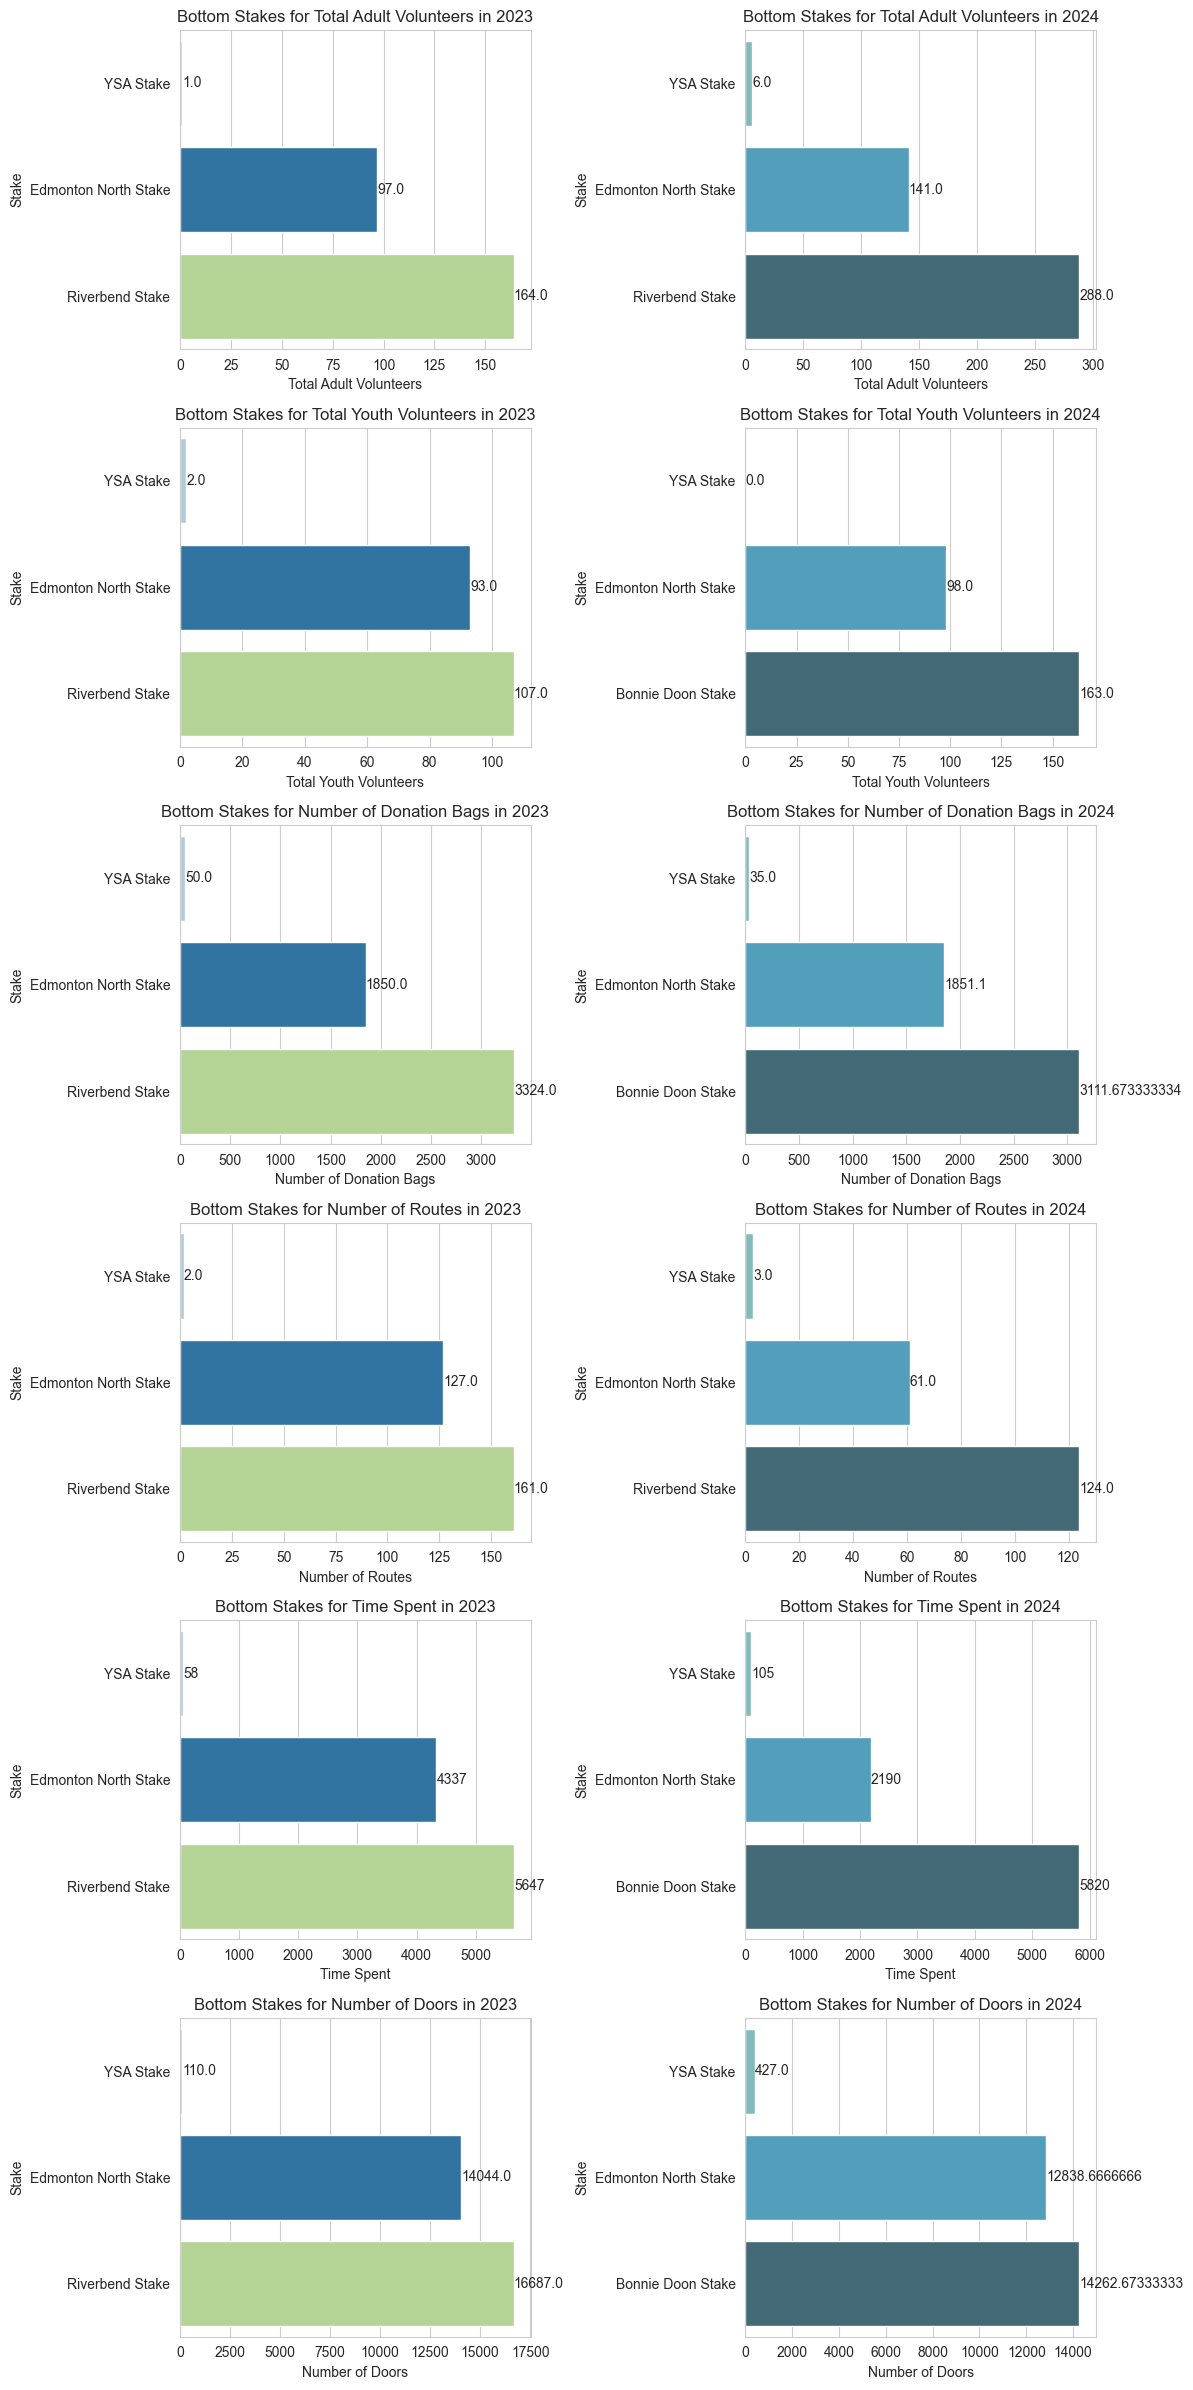

In [34]:
metrics = [
    'Total Adult Volunteers',
    'Total Youth Volunteers',
    'Number of Donation Bags',
    'Number of Routes',
    'Time Spent',
    'Number of Doors'
]

stake_totals = df_efd_cleaned.groupby(['Stake', 'Year'])[metrics].sum().reset_index()

n_metrics = len(metrics)
fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, n_metrics * 4))

for i, metric in enumerate(metrics):
    bottom_3_stakes_2023 = stake_totals[stake_totals['Year'] == 2023].nsmallest(3, metric)
    bottom_3_stakes_2024 = stake_totals[stake_totals['Year'] == 2024].nsmallest(3, metric)

    bottom_3_stakes_2023_sorted = bottom_3_stakes_2023.sort_values(by=metric, ascending=True)
    bottom_3_stakes_2024_sorted = bottom_3_stakes_2024.sort_values(by=metric, ascending=True)

    sns.barplot(x=metric, y='Stake', data=bottom_3_stakes_2023_sorted, ax=axes[i][0], palette='Paired', order=bottom_3_stakes_2023_sorted['Stake'])
    axes[i][0].set_title(f'Bottom Stakes for {metric} in 2023')
    axes[i][0].set_xlabel(metric)
    axes[i][0].set_ylabel('Stake')

    for index, value in enumerate(bottom_3_stakes_2023_sorted[metric]):
        axes[i][0].text(value, index, f'{value}', va='center')

    sns.barplot(x=metric, y='Stake', data=bottom_3_stakes_2024_sorted, ax=axes[i][1], palette='GnBu_d', order=bottom_3_stakes_2024_sorted['Stake'])
    axes[i][1].set_title(f'Bottom Stakes for {metric} in 2024')
    axes[i][1].set_xlabel(metric)
    axes[i][1].set_ylabel('Stake')

    for index, value in enumerate(bottom_3_stakes_2024_sorted[metric]):
        axes[i][1].text(value, index, f'{value}', va='center')

plt.tight_layout()
plt.show()

**Top 5 Wards in all categories**

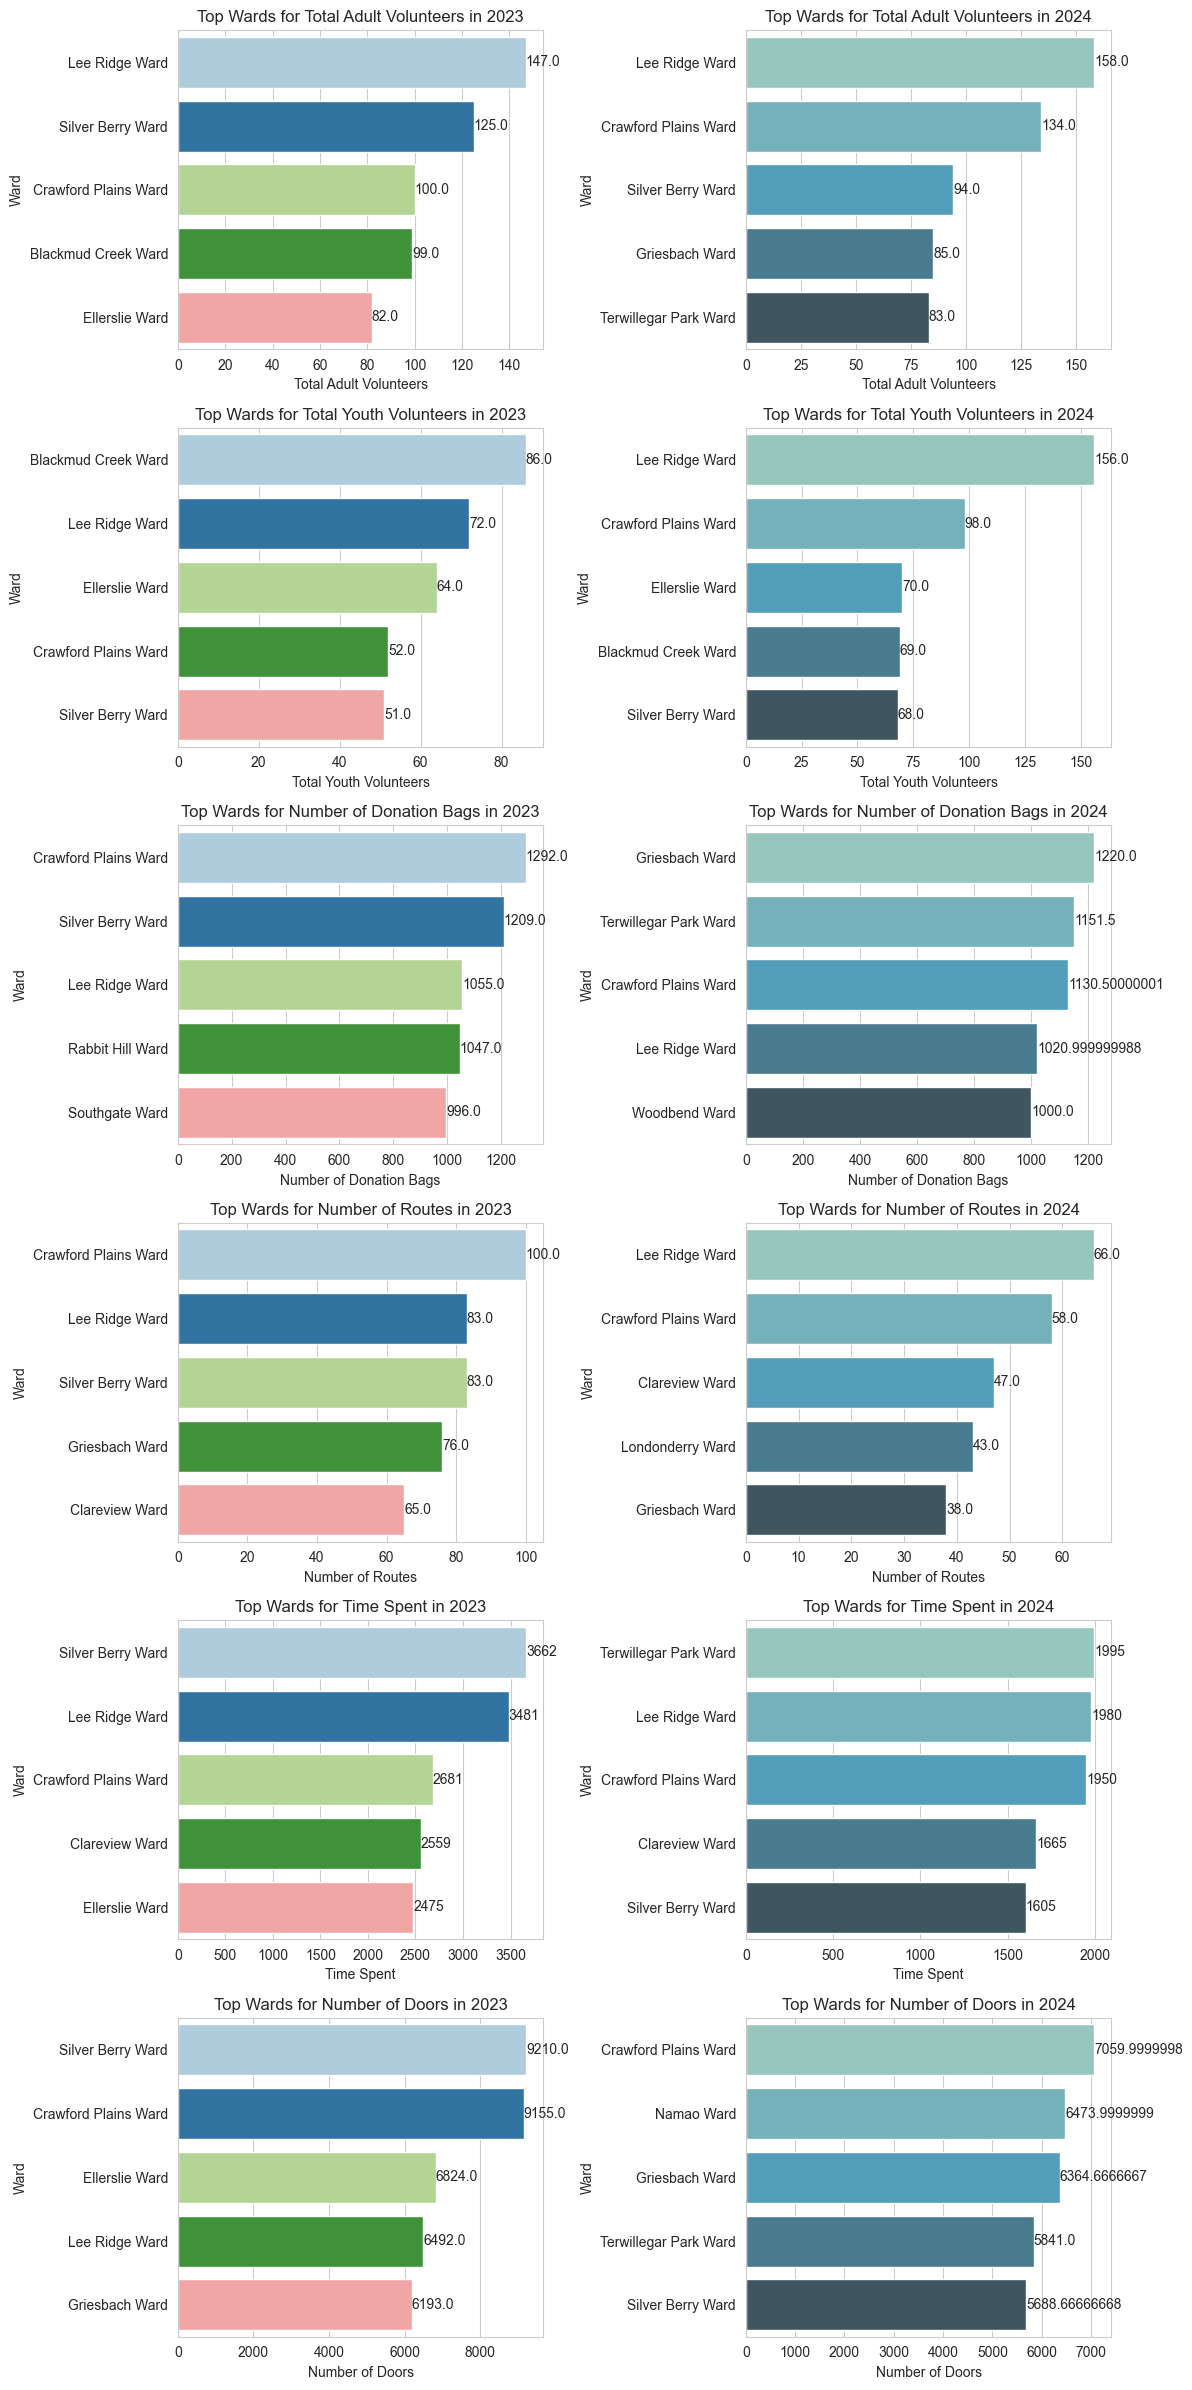

In [35]:
metrics = [
    'Total Adult Volunteers',
    'Total Youth Volunteers',
    'Number of Donation Bags',
    'Number of Routes',
    'Time Spent',
    'Number of Doors'
]

ward_totals = df_efd_cleaned.groupby(['Ward', 'Year'])[metrics].sum().reset_index()

n_metrics = len(metrics)
fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, n_metrics * 4))

for i, metric in enumerate(metrics):
    top_5_wards_2023 = ward_totals[ward_totals['Year'] == 2023].nlargest(5, metric)
    top_5_wards_2024 = ward_totals[ward_totals['Year'] == 2024].nlargest(5, metric)

    top_5_wards_2023_sorted = top_5_wards_2023.sort_values(by=metric, ascending=False)
    top_5_wards_2024_sorted = top_5_wards_2024.sort_values(by=metric, ascending=False)

    sns.barplot(x=metric, y='Ward', data=top_5_wards_2023_sorted, ax=axes[i][0], palette='Paired', order=top_5_wards_2023_sorted['Ward'])
    axes[i][0].set_title(f'Top Wards for {metric} in 2023')
    axes[i][0].set_xlabel(metric)
    axes[i][0].set_ylabel('Ward')

    for index, value in enumerate(top_5_wards_2023_sorted[metric]):
        axes[i][0].text(value, index, f'{value}', va='center')

    sns.barplot(x=metric, y='Ward', data=top_5_wards_2024_sorted, ax=axes[i][1], palette='GnBu_d', order=top_5_wards_2024_sorted['Ward'])
    axes[i][1].set_title(f'Top Wards for {metric} in 2024')
    axes[i][1].set_xlabel(metric)
    axes[i][1].set_ylabel('Ward')

    for index, value in enumerate(top_5_wards_2024_sorted[metric]):
        axes[i][1].text(value, index, f'{value}', va='center')

plt.tight_layout()
plt.show()

**Bottom 5 Wards in all categories**

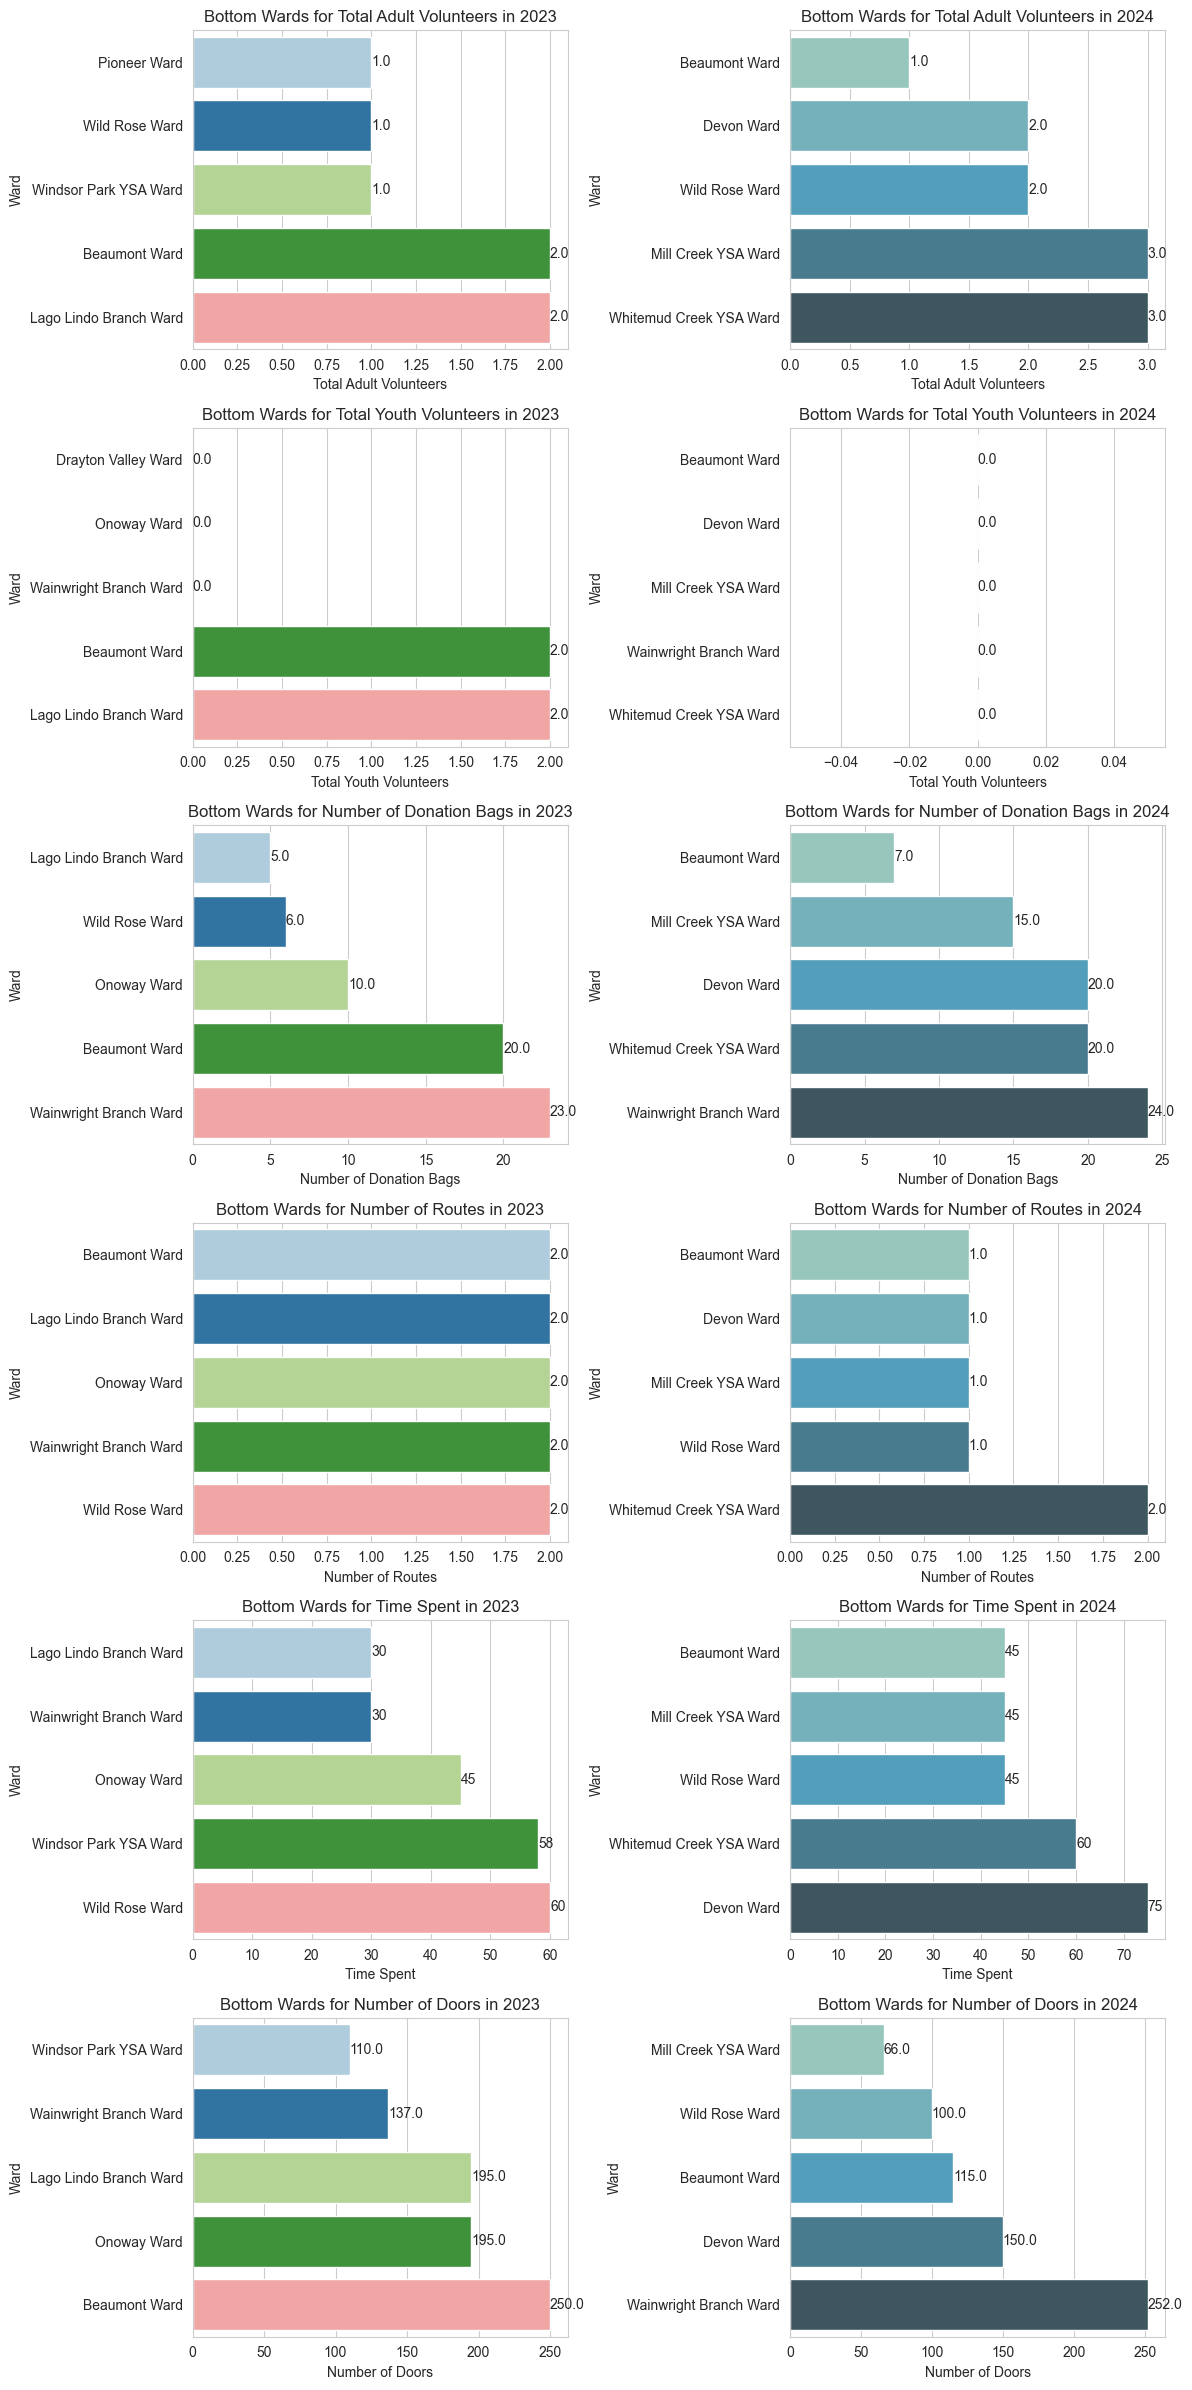

In [36]:
metrics = [
    'Total Adult Volunteers',
    'Total Youth Volunteers',
    'Number of Donation Bags',
    'Number of Routes',
    'Time Spent',
    'Number of Doors'
]

ward_totals = df_efd_cleaned.groupby(['Ward', 'Year'])[metrics].sum().reset_index()

n_metrics = len(metrics)
fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, n_metrics * 4))

for i, metric in enumerate(metrics):
    bottom_5_wards_2023 = ward_totals[ward_totals['Year'] == 2023].nsmallest(5, metric)
    bottom_5_wards_2024 = ward_totals[ward_totals['Year'] == 2024].nsmallest(5, metric)

    bottom_5_wards_2023_sorted = bottom_5_wards_2023.sort_values(by=metric, ascending=True)
    bottom_5_wards_2024_sorted = bottom_5_wards_2024.sort_values(by=metric, ascending=True)

    sns.barplot(x=metric, y='Ward', data=bottom_5_wards_2023_sorted, ax=axes[i][0], palette='Paired', order=bottom_5_wards_2023_sorted['Ward'])
    axes[i][0].set_title(f'Bottom Wards for {metric} in 2023')
    axes[i][0].set_xlabel(metric)
    axes[i][0].set_ylabel('Ward')

    for index, value in enumerate(bottom_5_wards_2023_sorted[metric]):
        axes[i][0].text(value, index, f'{value}', va='center')

    sns.barplot(x=metric, y='Ward', data=bottom_5_wards_2024_sorted, ax=axes[i][1], palette='GnBu_d', order=bottom_5_wards_2024_sorted['Ward'])
    axes[i][1].set_title(f'Bottom Wards for {metric} in 2024')
    axes[i][1].set_xlabel(metric)
    axes[i][1].set_ylabel('Ward')

    for index, value in enumerate(bottom_5_wards_2024_sorted[metric]):
        axes[i][1].text(value, index, f'{value}', va='center')

plt.tight_layout()
plt.show()

**Top 5 Wards in terms of efficiency**

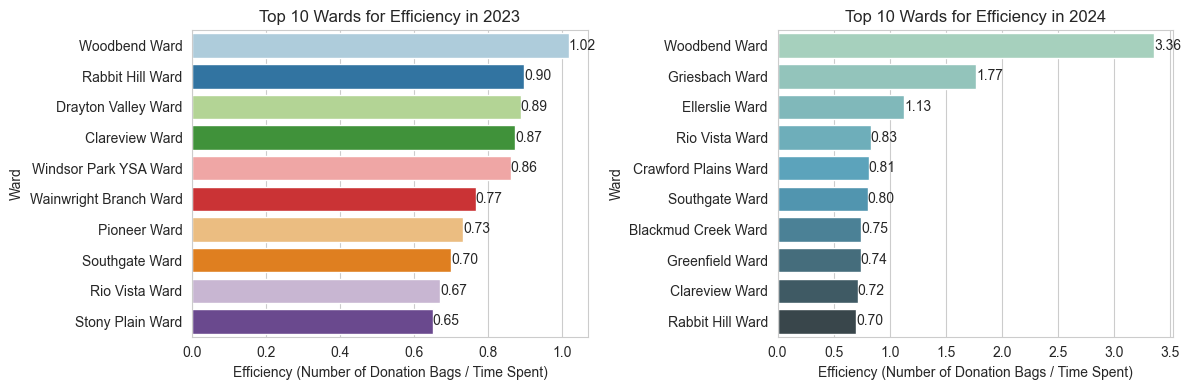

In [37]:
df_efd_cleaned['Efficiency'] = df_efd_cleaned['Number of Donation Bags'] / df_efd_cleaned['Time Spent']
ward_totals = df_efd_cleaned.groupby(['Ward', 'Year']).agg({
    'Total Adult Volunteers': 'sum',
    'Total Youth Volunteers': 'sum',
    'Number of Donation Bags': 'sum',
    'Number of Routes': 'sum',
    'Time Spent': 'sum',
    'Number of Doors': 'sum',
    'Efficiency': 'mean'
}).reset_index()

n_metrics = 1
fig, axes = plt.subplots(nrows=n_metrics, ncols=2, figsize=(12, n_metrics * 4))

top_10_wards_2023 = ward_totals[ward_totals['Year'] == 2023].nlargest(10, 'Efficiency').sort_values(by='Efficiency', ascending=False)
top_10_wards_2024 = ward_totals[ward_totals['Year'] == 2024].nlargest(10, 'Efficiency').sort_values(by='Efficiency', ascending=False)

sns.barplot(x='Efficiency', y='Ward', data=top_10_wards_2023, ax=axes[0], palette='Paired', order=top_10_wards_2023['Ward'])
axes[0].set_title('Top 10 Wards for Efficiency in 2023')
axes[0].set_xlabel('Efficiency (Number of Donation Bags / Time Spent)')
axes[0].set_ylabel('Ward')

for index, value in enumerate(top_10_wards_2023['Efficiency']):
    axes[0].text(value, index, f'{value:.2f}', va='center')

sns.barplot(x='Efficiency', y='Ward', data=top_10_wards_2024, ax=axes[1], palette='GnBu_d', order=top_10_wards_2024['Ward'])
axes[1].set_title('Top 10 Wards for Efficiency in 2024')
axes[1].set_xlabel('Efficiency (Number of Donation Bags / Time Spent)')
axes[1].set_ylabel('Ward')

for index, value in enumerate(top_10_wards_2024['Efficiency']):
    axes[1].text(value, index, f'{value:.2f}', va='center')

plt.tight_layout()
plt.show()

**Threshold Analysis: Routes Taking Over 60 Minutes to Complete**

In [38]:
df_filtered = df_efd_cleaned[df_efd_cleaned['Route Information'] != 'Route Unknown']
df_filtered['Route Information'] = df_filtered['Route Information'].astype(str)

route_totals = df_filtered.groupby(['Ward', 'Route Information']).agg({
    'Time Spent': 'sum'
}).reset_index()

route_totals = route_totals[route_totals['Time Spent'] > 0]
route_totals['Time Spent Threshold'] = route_totals['Time Spent'].apply(lambda x: 1 if x > 60 else 0)
unique_wards = route_totals['Ward'].unique()

for ward in unique_wards:
    print(f"\nRoutes with Time Spent > 60 minutes for Ward: {ward}")
    ward_routes = route_totals[(route_totals['Ward'] == ward) & (route_totals['Time Spent Threshold'] == 1)]
    print(ward_routes['Route Information'].to_list())


Routes with Time Spent > 60 minutes for Ward: Beaumont Ward
[]

Routes with Time Spent > 60 minutes for Ward: Blackmud Creek Ward
['Route 12', 'Route 15', 'Route 20', 'Route 27', 'Route 4', 'Route 46', 'Route 7', 'Route 8']

Routes with Time Spent > 60 minutes for Ward: Clareview Ward
['Route 101', 'Route 118', 'Route 121', 'Route 131', 'Route 138', 'Route 168', 'Route 199', 'Route 205', 'Route 212']

Routes with Time Spent > 60 minutes for Ward: Connors Hill Ward
['Route 1', 'Route 2', 'Route 3', 'Route 4', 'Route 5', 'Route 63', 'Route 8']

Routes with Time Spent > 60 minutes for Ward: Crawford Plains Ward
['Route 10', 'Route 11', 'Route 15', 'Route 19', 'Route 21', 'Route 22', 'Route 23', 'Route 36', 'Route 6', 'Route 8', 'Route 86', 'Route 9']

Routes with Time Spent > 60 minutes for Ward: Devon Ward
['Route 9']

Routes with Time Spent > 60 minutes for Ward: Ellerslie Ward
['Route 12', 'Route 18']

Routes with Time Spent > 60 minutes for Ward: Forest Heights Ward
['Route 1', 'Rout

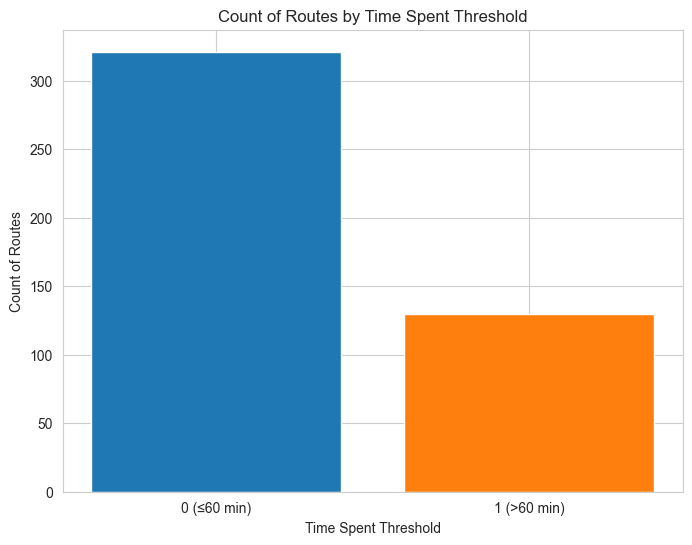

In [39]:
threshold_counts = route_totals['Time Spent Threshold'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(threshold_counts.index, threshold_counts.values, color=['#1f77b4', '#ff7f0e'])
plt.xticks([0, 1], ['0 (≤60 min)', '1 (>60 min)'])
plt.title('Count of Routes by Time Spent Threshold')
plt.xlabel('Time Spent Threshold')
plt.ylabel('Count of Routes')
plt.show()

**Total Donation Bags per Route**

In [40]:
wards_per_stake = {
    "Bonnie Doon Stake": [
        "Clareview Ward",
        "Connors Hill Ward",
        "Coronation Park Ward",
        "Forest Heights Ward",
        "Londonderry Ward",
        "Southgate Ward",
        "Strathcona Married Student Ward"
    ],
    "Edmonton North Stake": [
        "Griesbach Ward",
        "Lago Lindo Branch Ward",
        "Namao Ward",
        "Onoway Ward",
        "Pioneer Ward",
        "Stony Plain Ward"
    ],
    "Gateway Stake": [
        "Beaumont Ward",
        "Blackmud Creek Ward",
        "Crawford Plains Ward",
        "Ellerslie Ward",
        "Lee Ridge Ward",
        "Rio Vista Ward",
        "Silver Berry Ward",
        "Wainwright Branch Ward",
        "Wild Rose Ward"
    ],
    "Riverbend Stake": [
        "Devon Ward",
        "Drayton Valley Ward",
        "Greenfield Ward",
        "Rabbit Hill Ward",
        "Rutherford Ward",
        "Terwillegar Park Ward",
        "Woodbend Ward"
    ],
    "YSA Stake": [
        "Mill Creek YSA Ward",
        "Whitemud Creek YSA Ward",
        "Windsor Park YSA Ward"
    ]
}

stake_dfs = {}

for stake, wards in wards_per_stake.items():
    stake_donations = df_efd_cleaned[df_efd_cleaned['Ward'].isin(wards)]
    summarized_data = stake_donations.groupby(['Ward', 'Route Information'])['Number of Donation Bags'].sum().reset_index()
    summarized_data = summarized_data[summarized_data['Number of Donation Bags'] > 0]
    summarized_data['Stake'] = stake

    if not summarized_data.empty:
        stake_dfs[stake] = summarized_data

for stake, df in stake_dfs.items():
    styled_df = df[['Ward', 'Route Information', 'Number of Donation Bags']].style.set_caption(f"Records for {stake}")
    display(styled_df)
    print("\n")

,Ward,Route Information,Number of Donation Bags
0,Clareview Ward,Route 101,24.000000
1,Clareview Ward,Route 110,26.000000
2,Clareview Ward,Route 118,22.500000
3,Clareview Ward,Route 120,25.000000
4,Clareview Ward,Route 121,22.500000
5,Clareview Ward,Route 123,42.000000
6,Clareview Ward,Route 126,19.000000
7,Clareview Ward,Route 128,30.000000
8,Clareview Ward,Route 129,9.000000
9,Clareview Ward,Route 131,48.663333


,Ward,Route Information,Number of Donation Bags
0,Griesbach Ward,Route 1,22.000000
1,Griesbach Ward,Route 1A,288.000000
2,Griesbach Ward,Route 1B,250.000000
3,Griesbach Ward,Route 2,12.000000
4,Griesbach Ward,Route 3,12.000000
5,Griesbach Ward,Route 3C,20.000000
6,Griesbach Ward,Route A,47.750000
7,Griesbach Ward,Route B,50.350000
8,Griesbach Ward,Route B,24.000000
9,Griesbach Ward,Route C,40.850000


,Ward,Route Information,Number of Donation Bags
0,Beaumont Ward,Route 40,7.000000
1,Beaumont Ward,Route Unknown,20.000000
2,Blackmud Creek Ward,Route 1,26.000000
3,Blackmud Creek Ward,Route 10,36.000000
4,Blackmud Creek Ward,Route 12,53.000000
5,Blackmud Creek Ward,Route 13,35.000000
6,Blackmud Creek Ward,Route 15,35.000000
7,Blackmud Creek Ward,Route 18,22.000000
8,Blackmud Creek Ward,Route 2,20.000000
9,Blackmud Creek Ward,Route 20,100.000000


,Ward,Route Information,Number of Donation Bags
0,Devon Ward,Route 9,20.000000
1,Drayton Valley Ward,Route Unknown,80.000000
2,Greenfield Ward,Route 1,66.000000
3,Greenfield Ward,Route 197,45.000000
4,Greenfield Ward,Route 2,41.000000
5,Greenfield Ward,Route 3,149.000000
6,Greenfield Ward,Route 4,24.000000
7,Greenfield Ward,Route 5,45.000000
8,Greenfield Ward,Route 6,37.000000
9,Greenfield Ward,Route AG1,50.000000


,Ward,Route Information,Number of Donation Bags
0,Mill Creek YSA Ward,Route 4,15.000000
1,Whitemud Creek YSA Ward,Route 2,12.000000
2,Whitemud Creek YSA Ward,Route Unknown,8.000000
3,Windsor Park YSA Ward,Route Unknown,50.000000


**Top and Bottom 5 Routes per Number of Donation Bags**

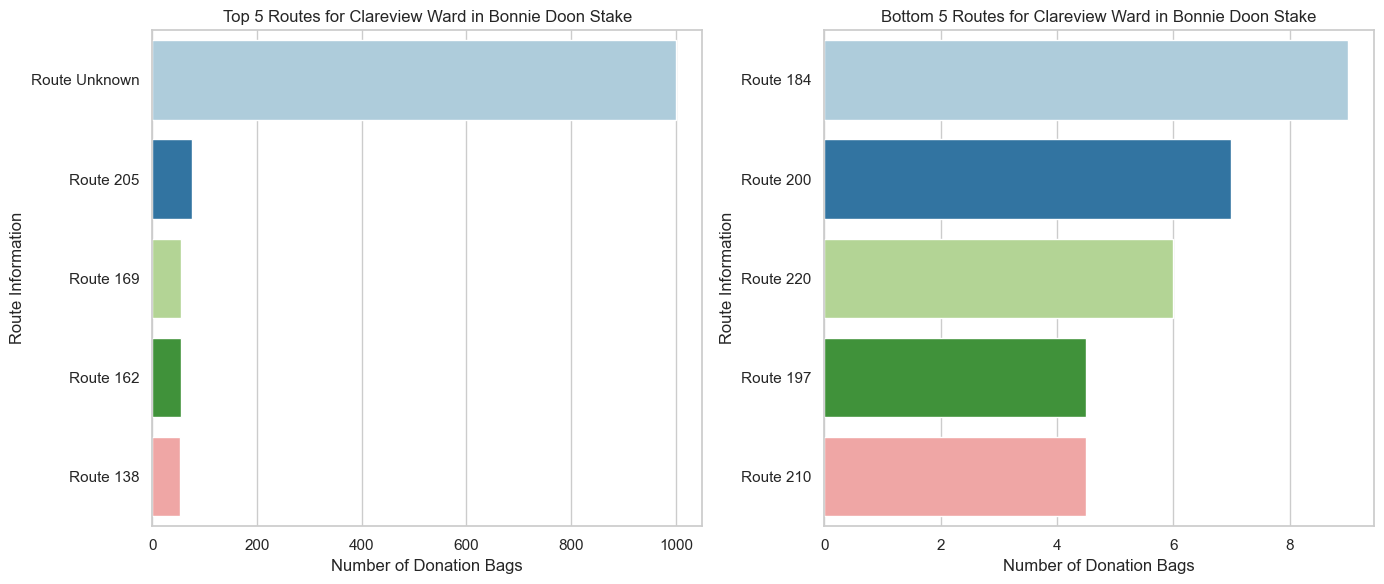

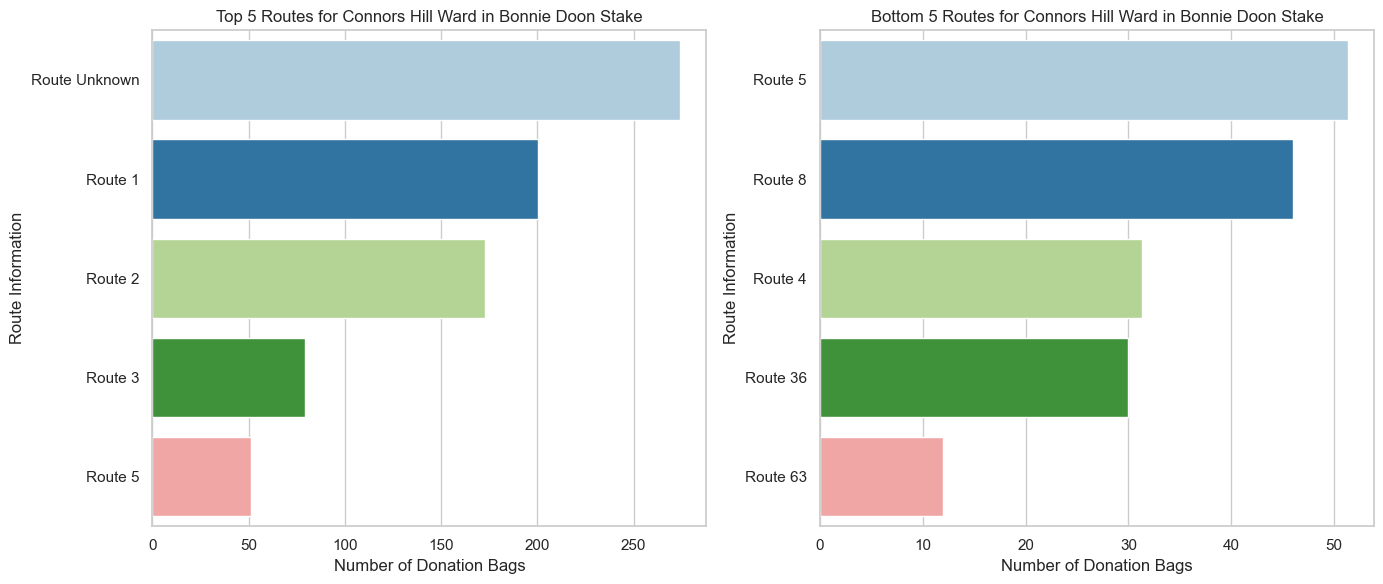

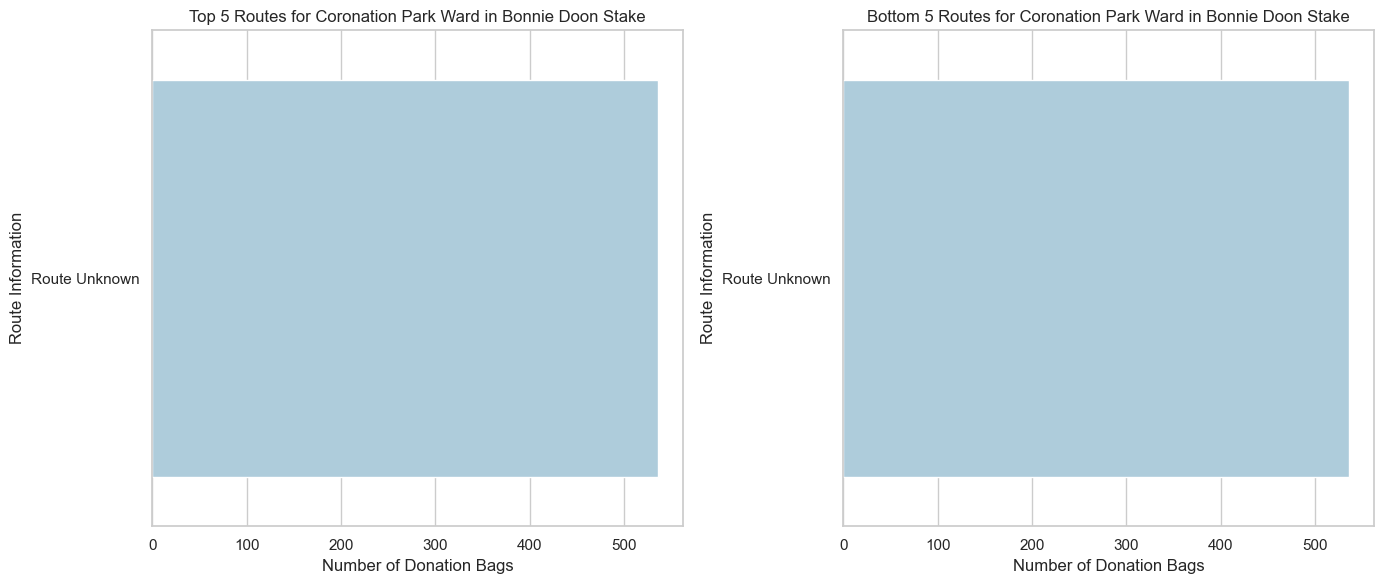

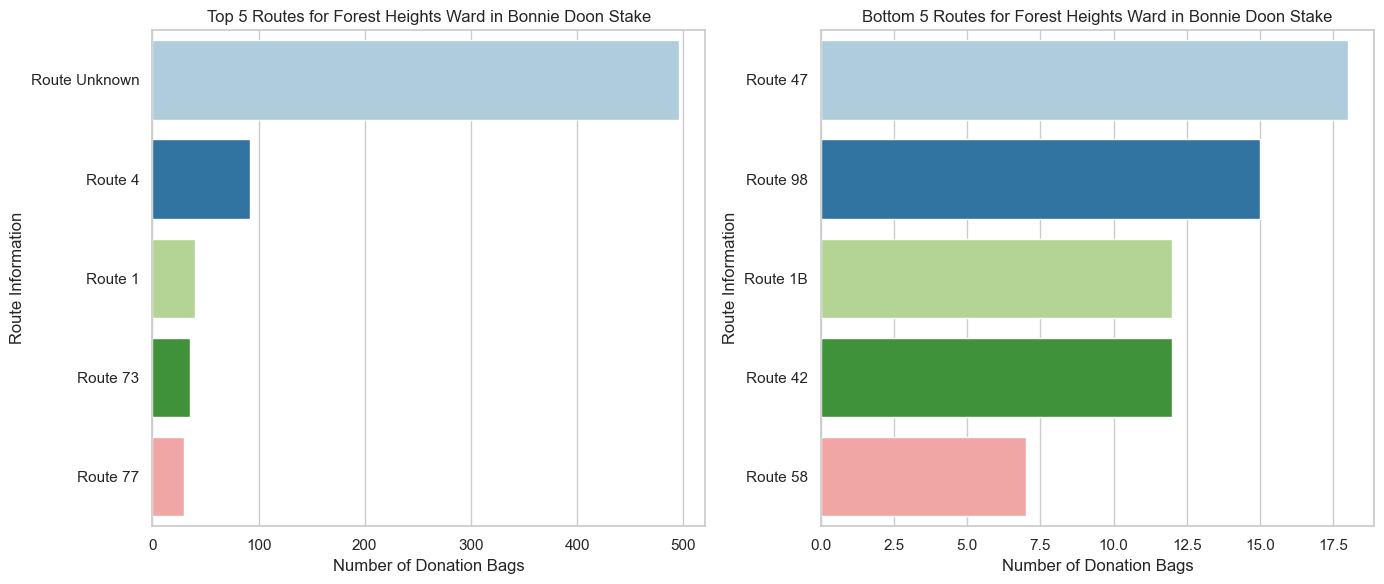

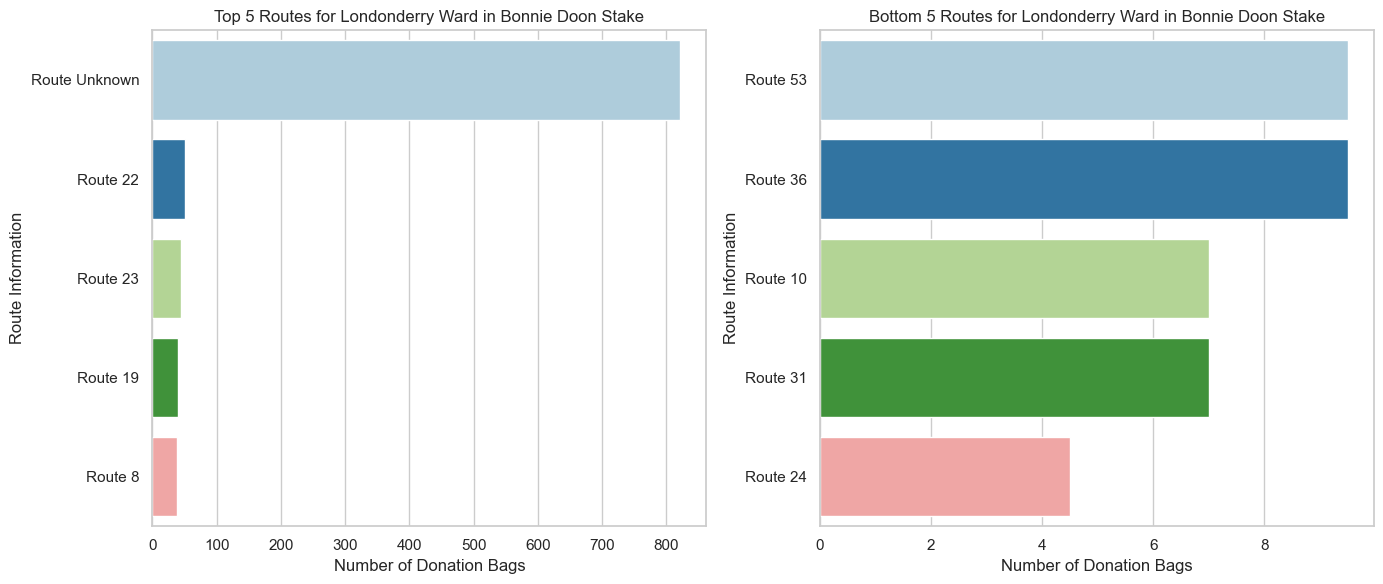

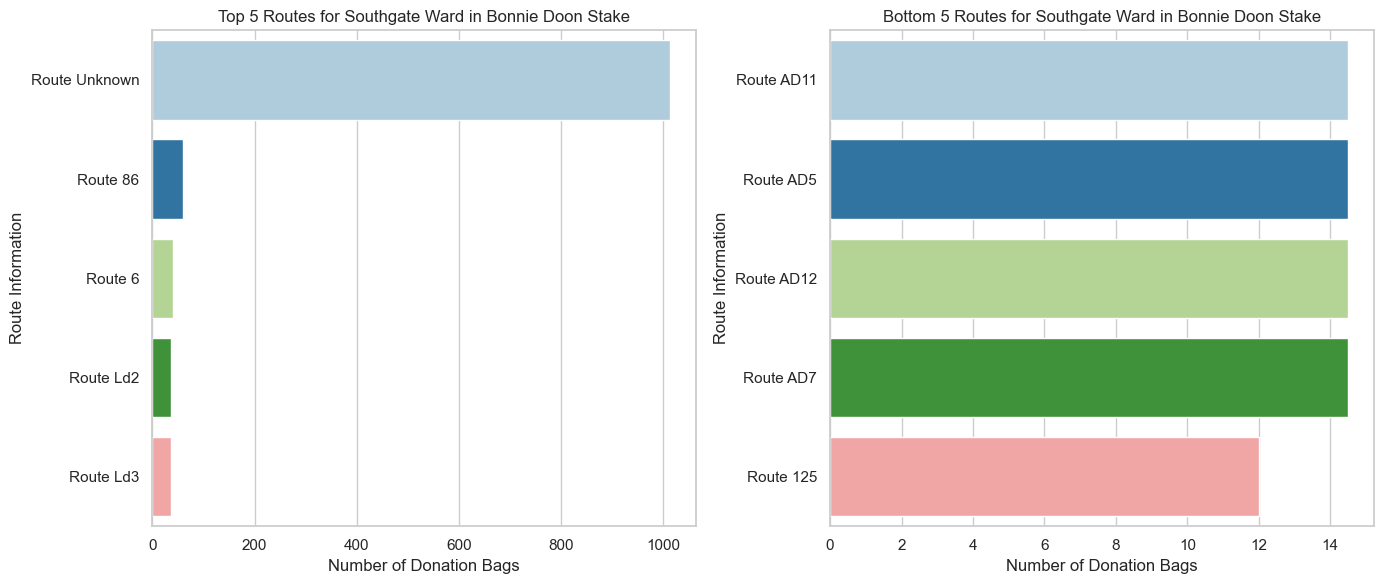

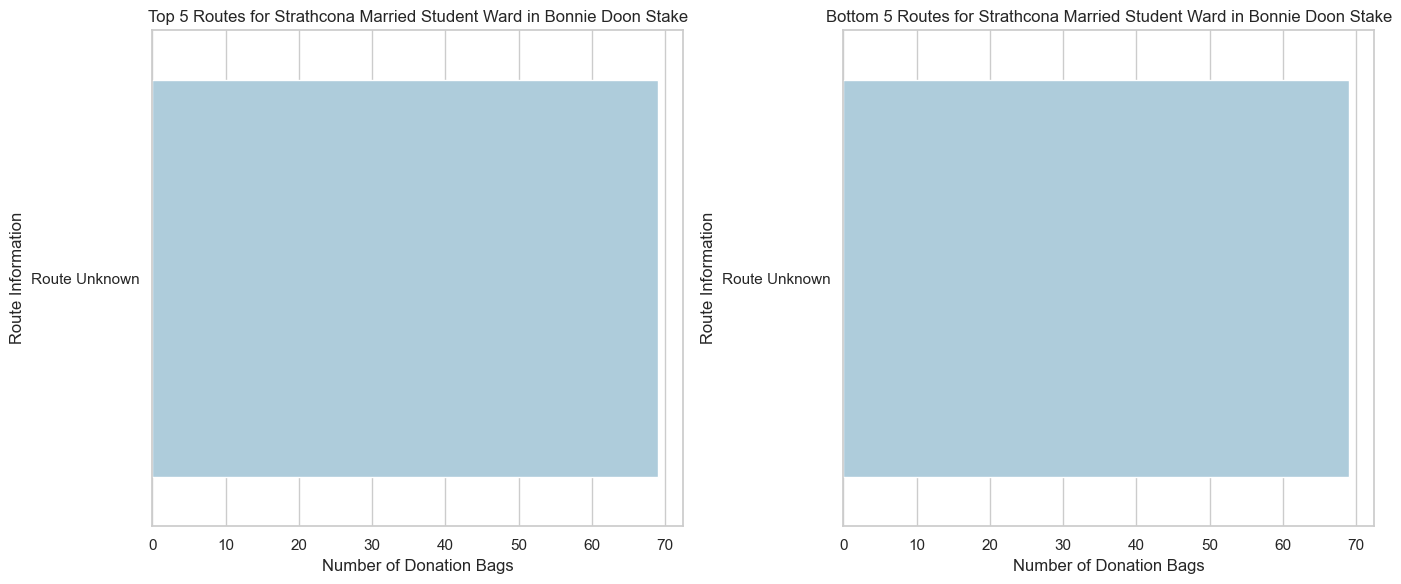

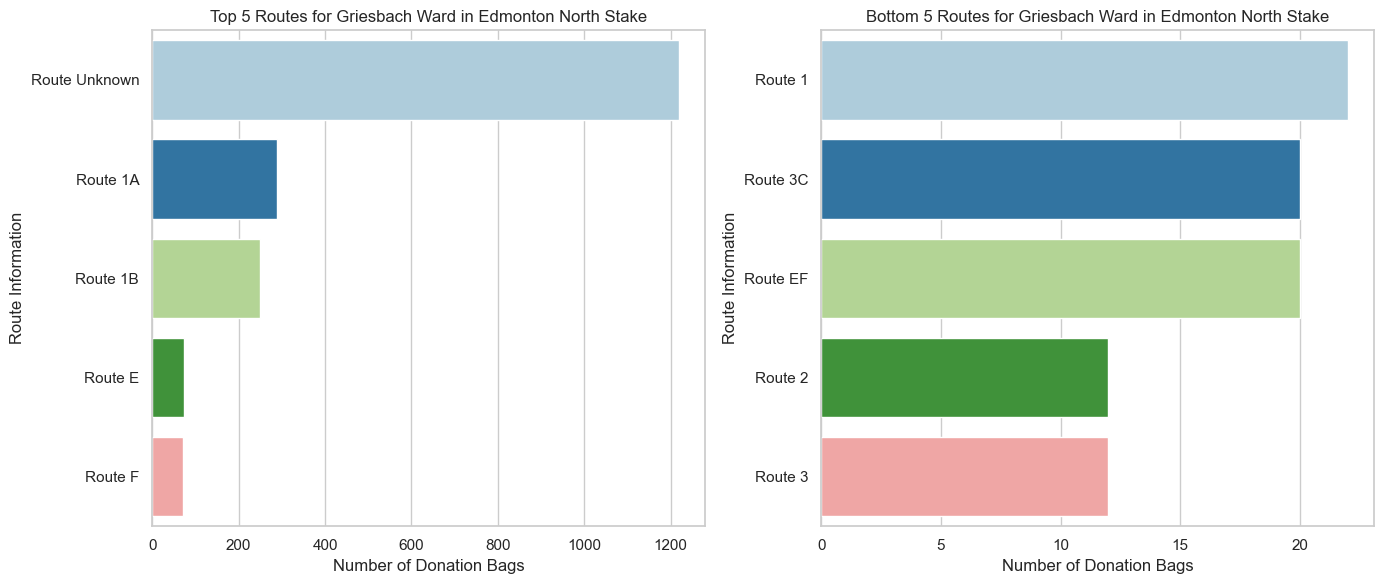

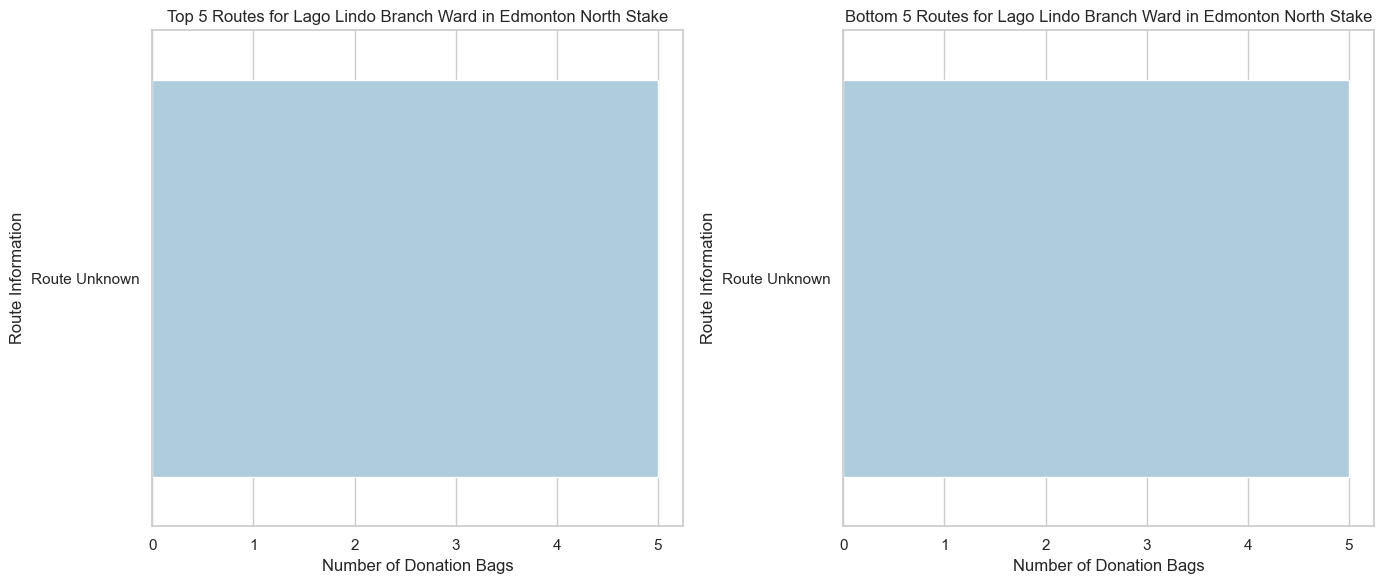

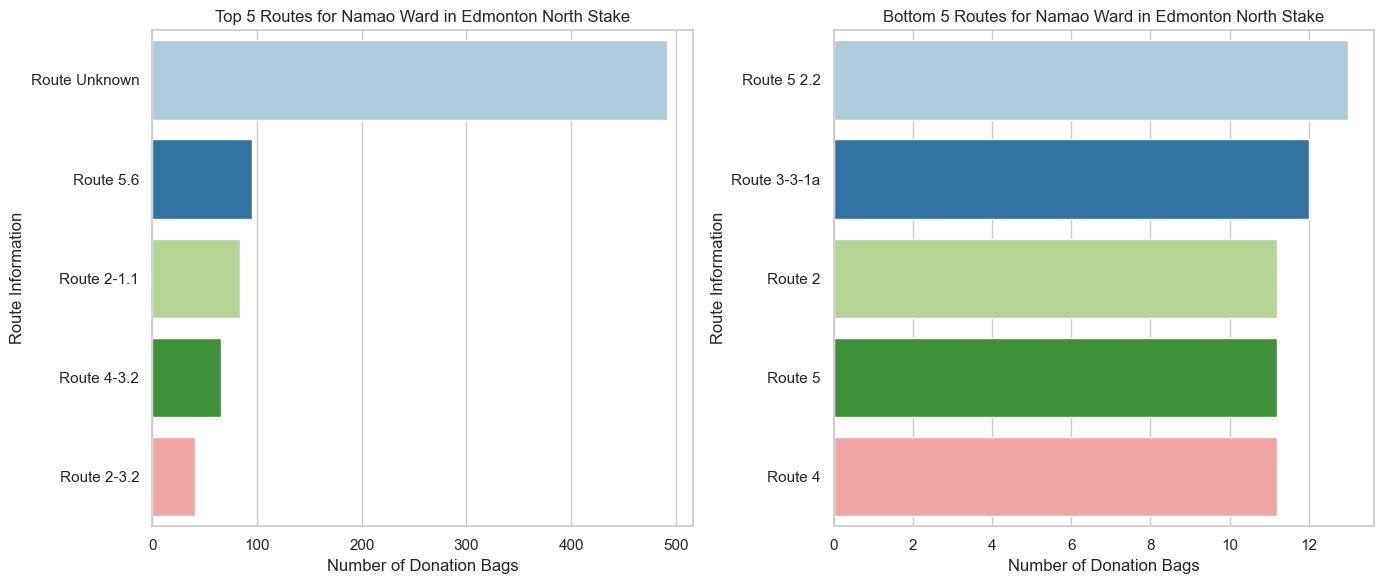

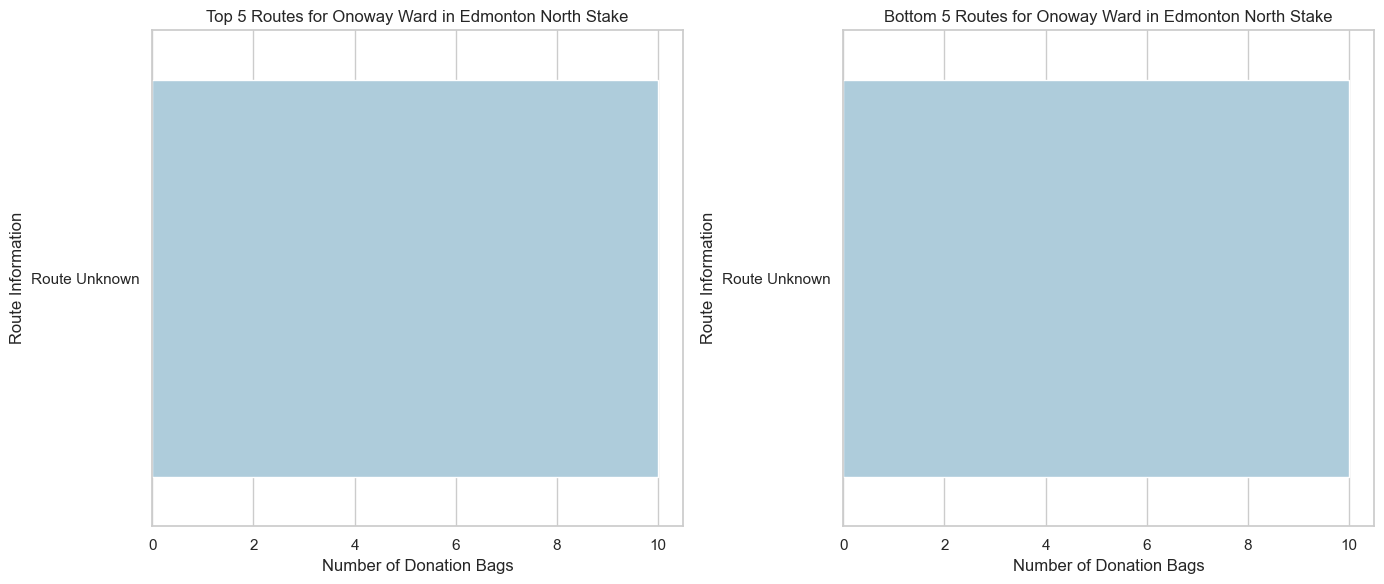

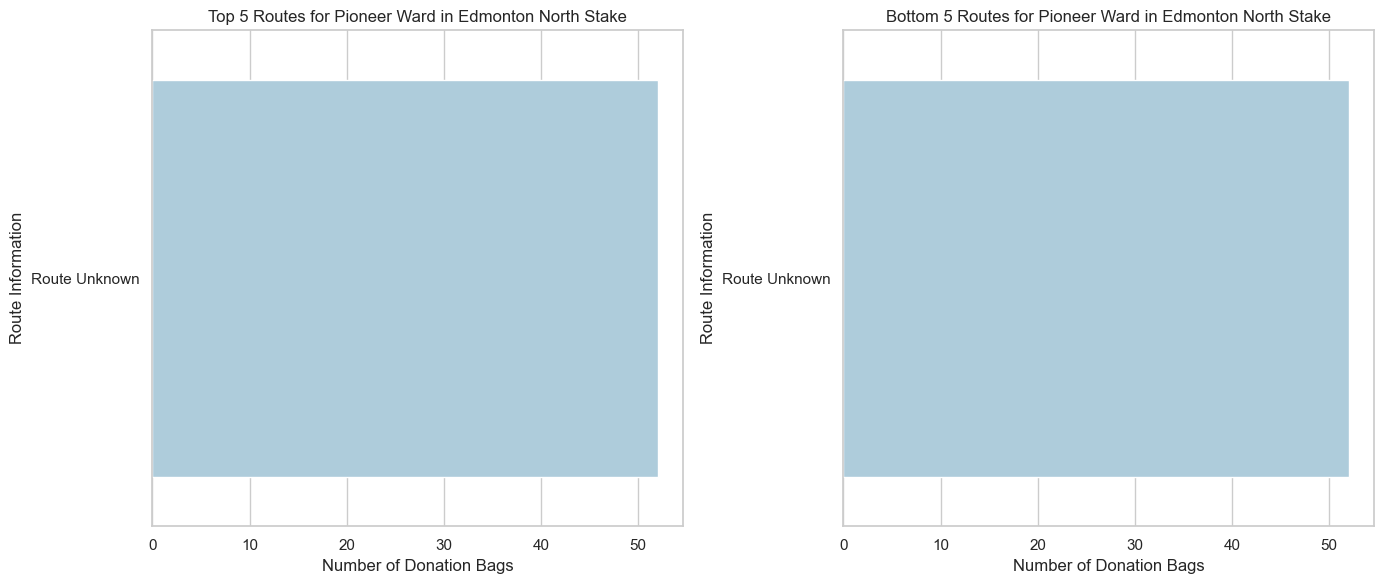

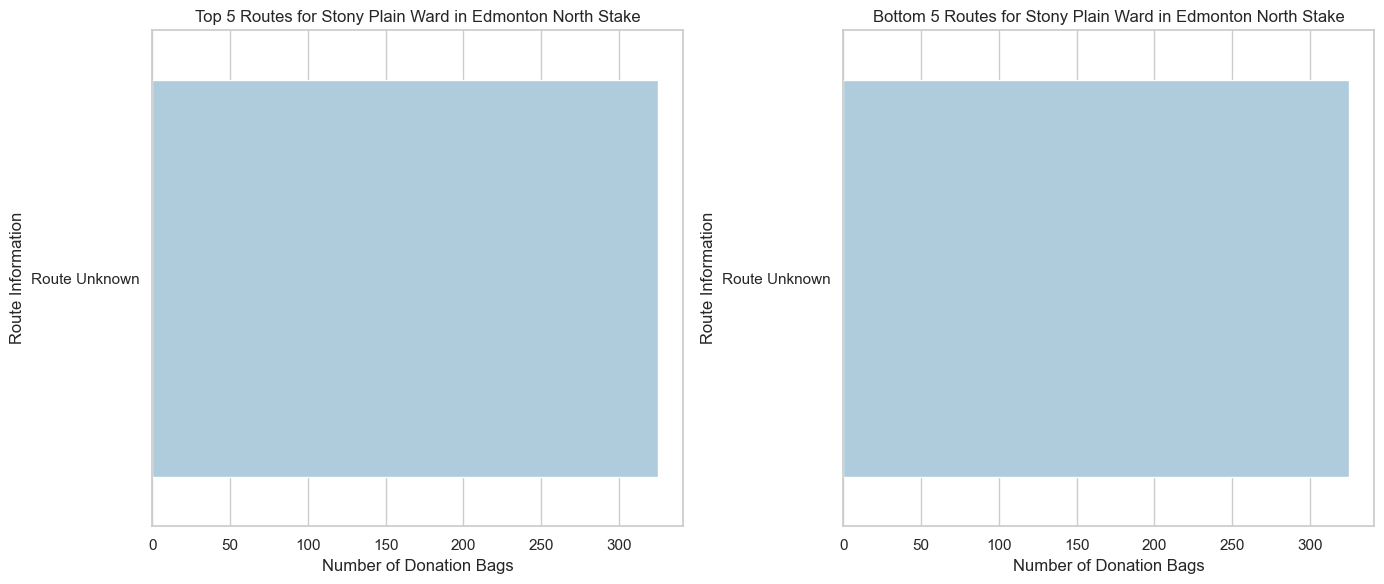

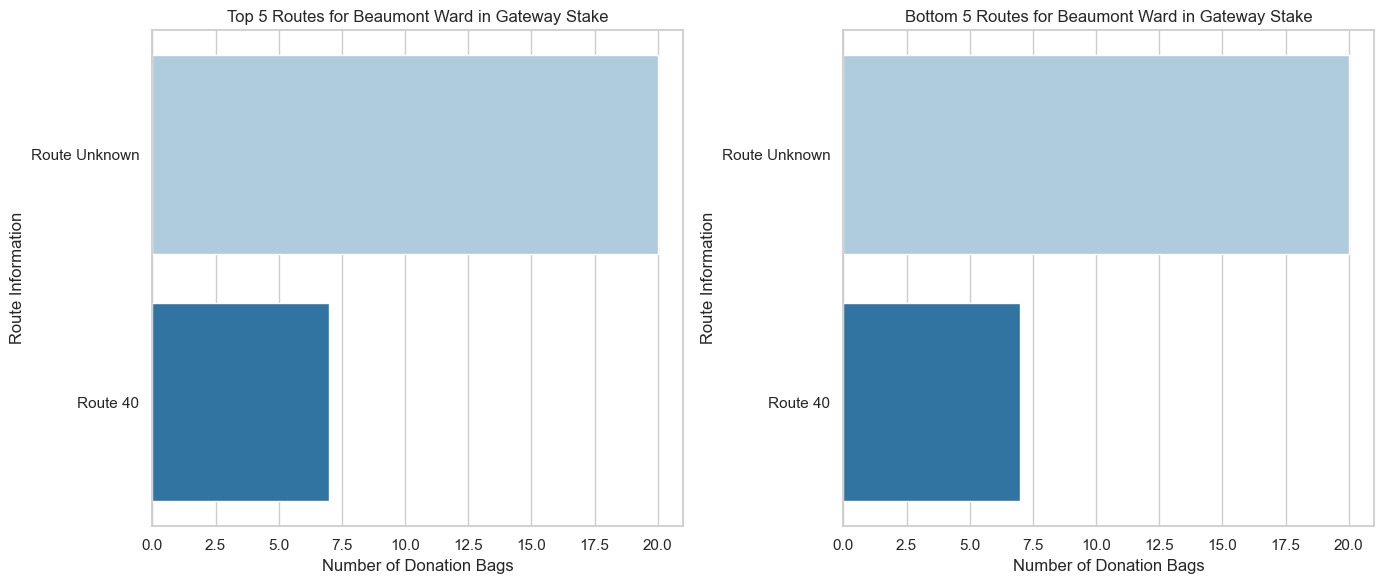

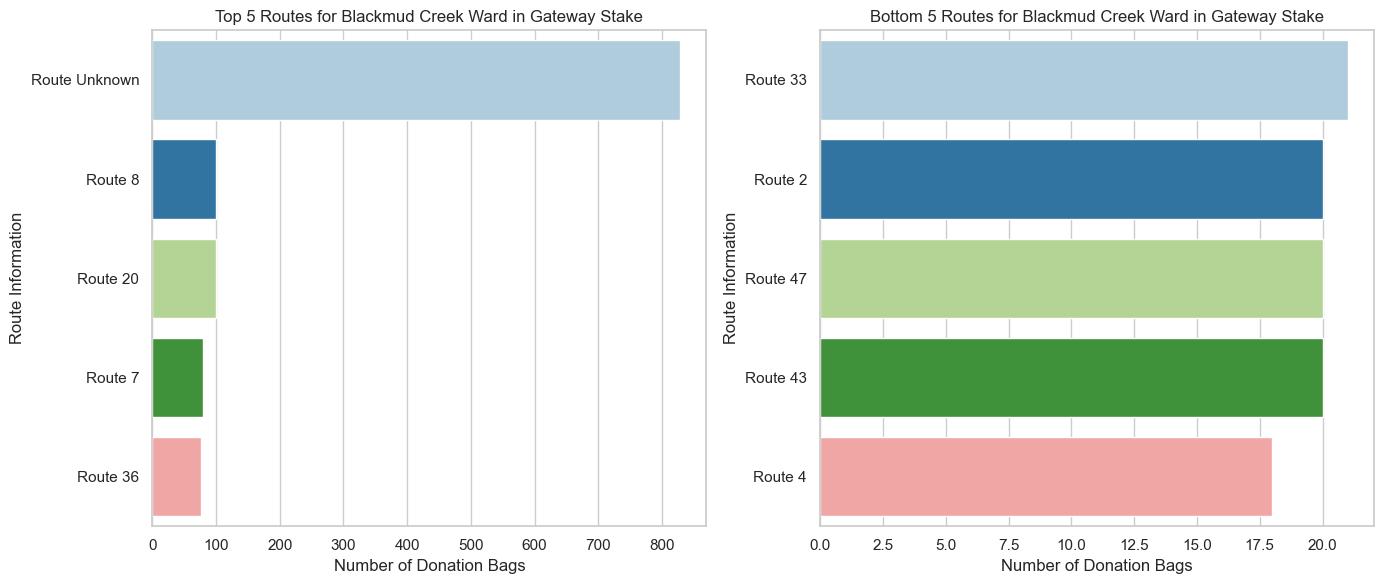

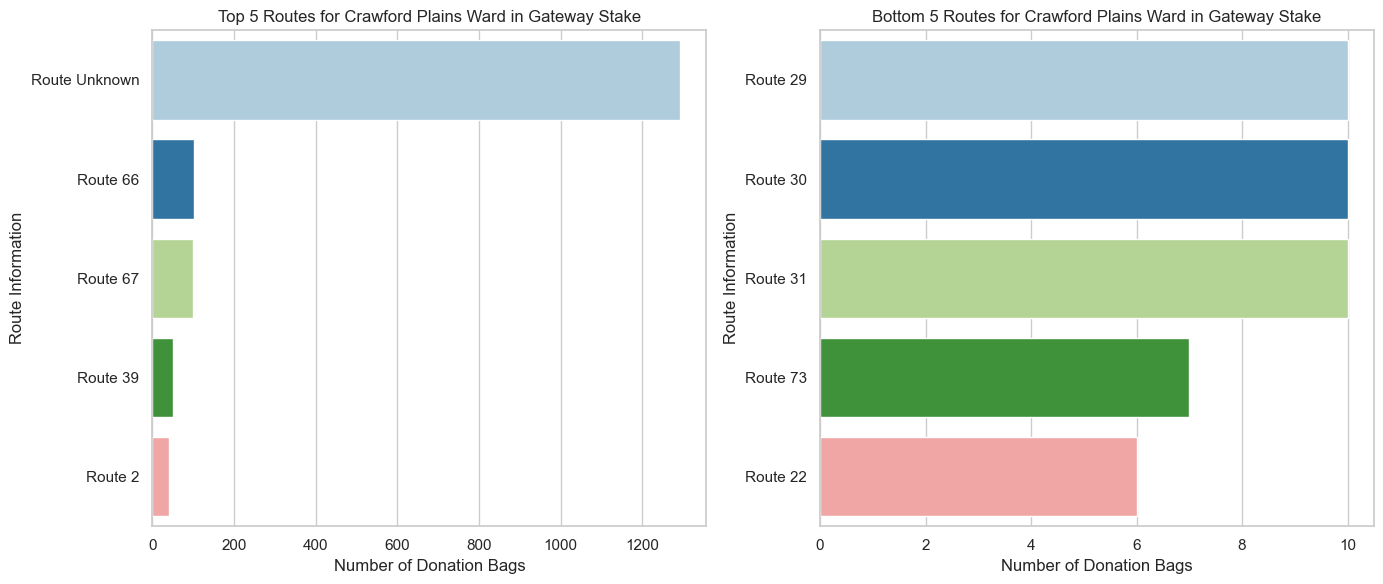

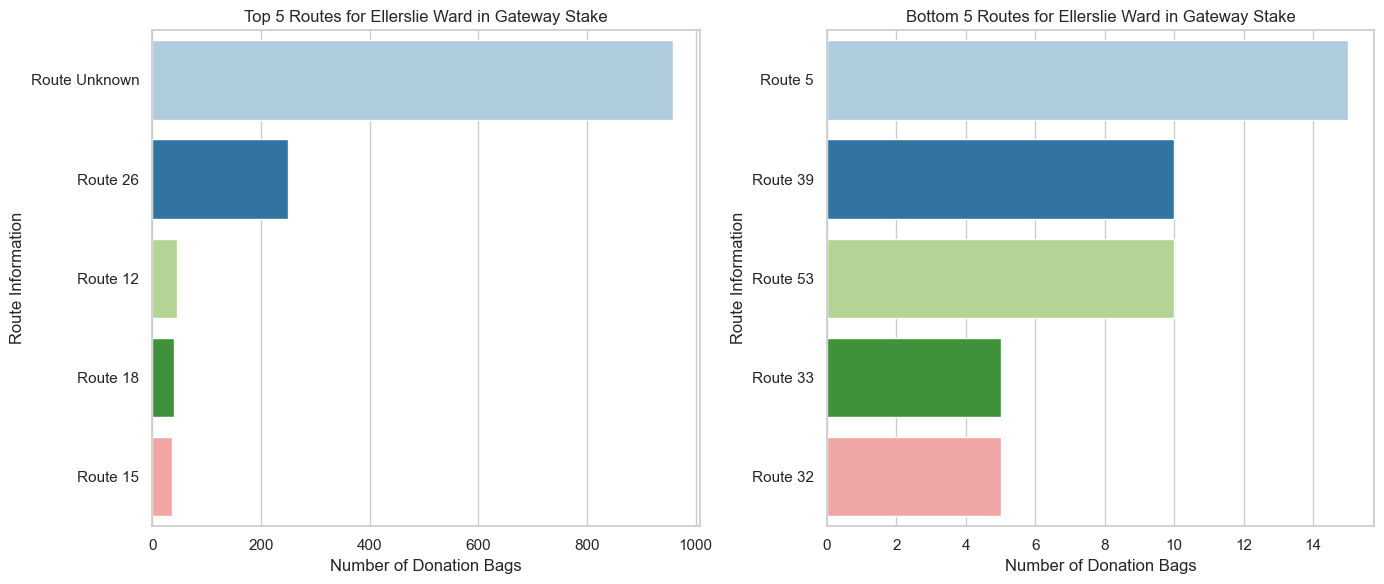

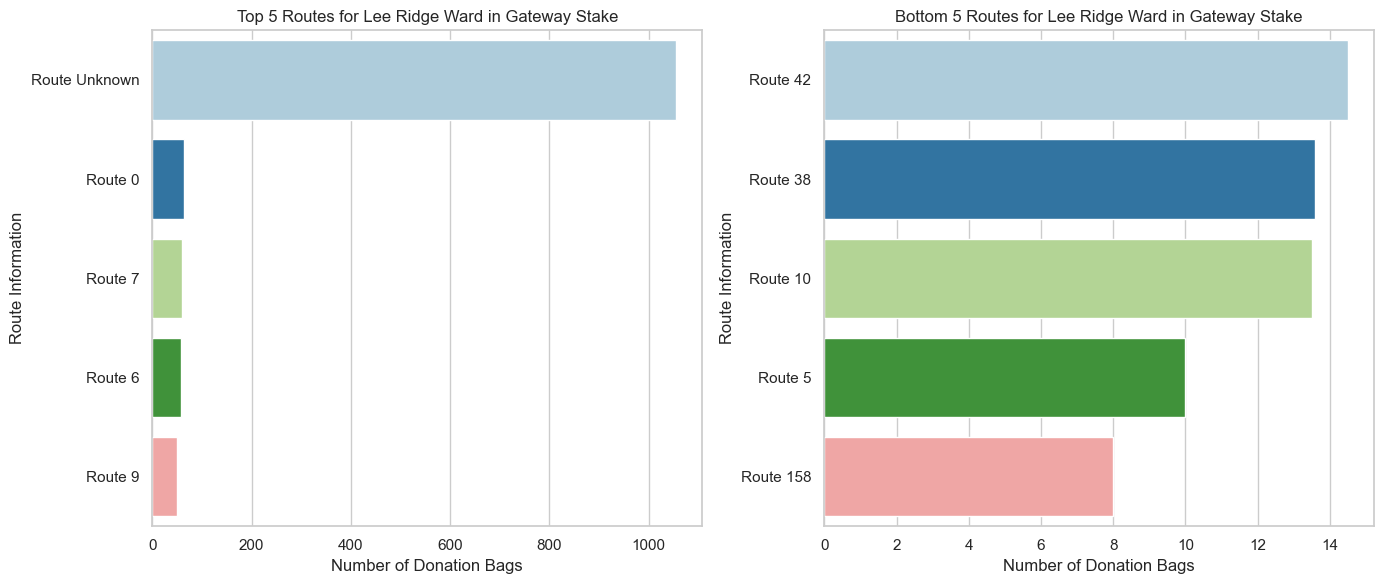

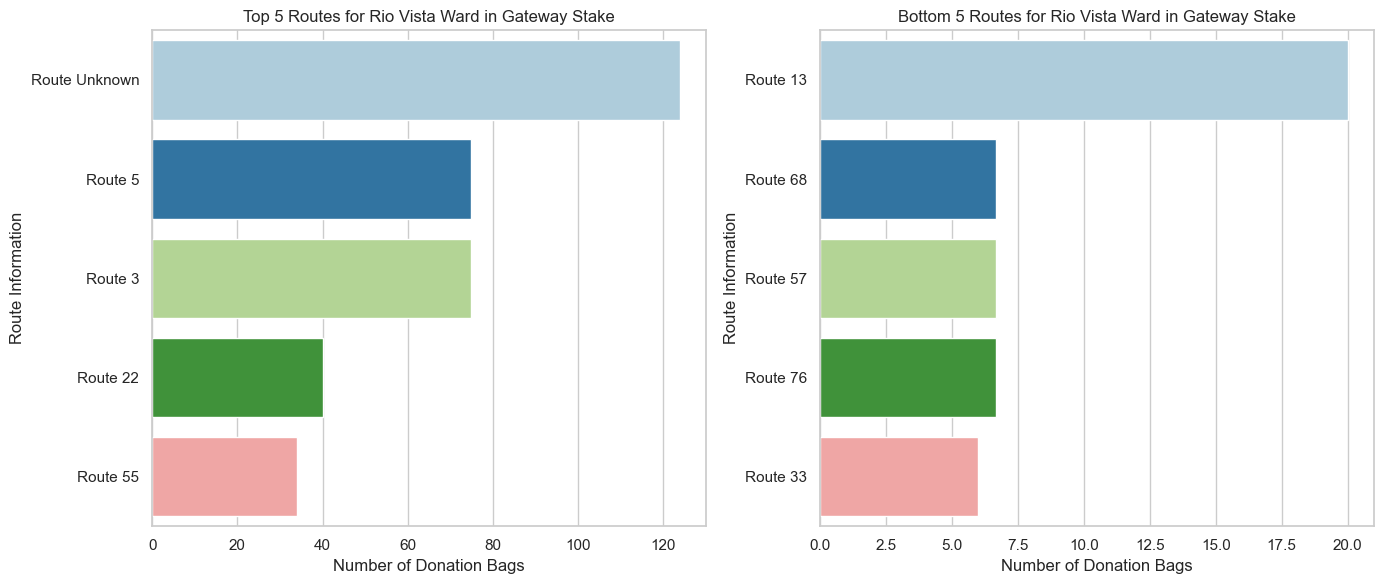

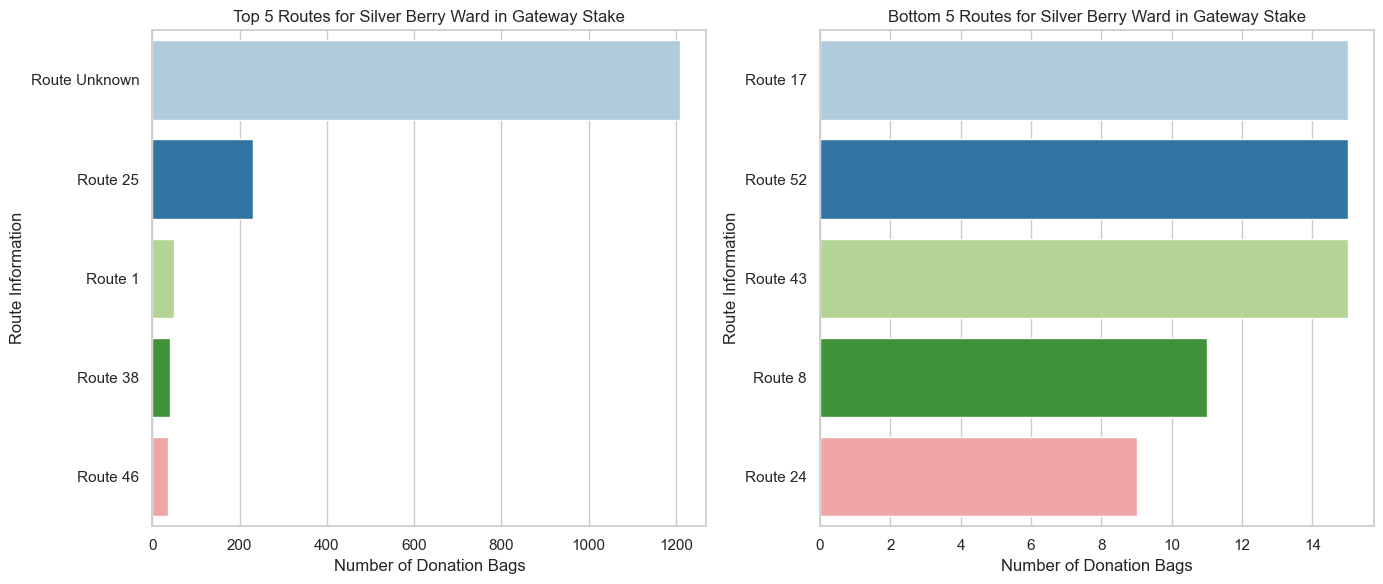

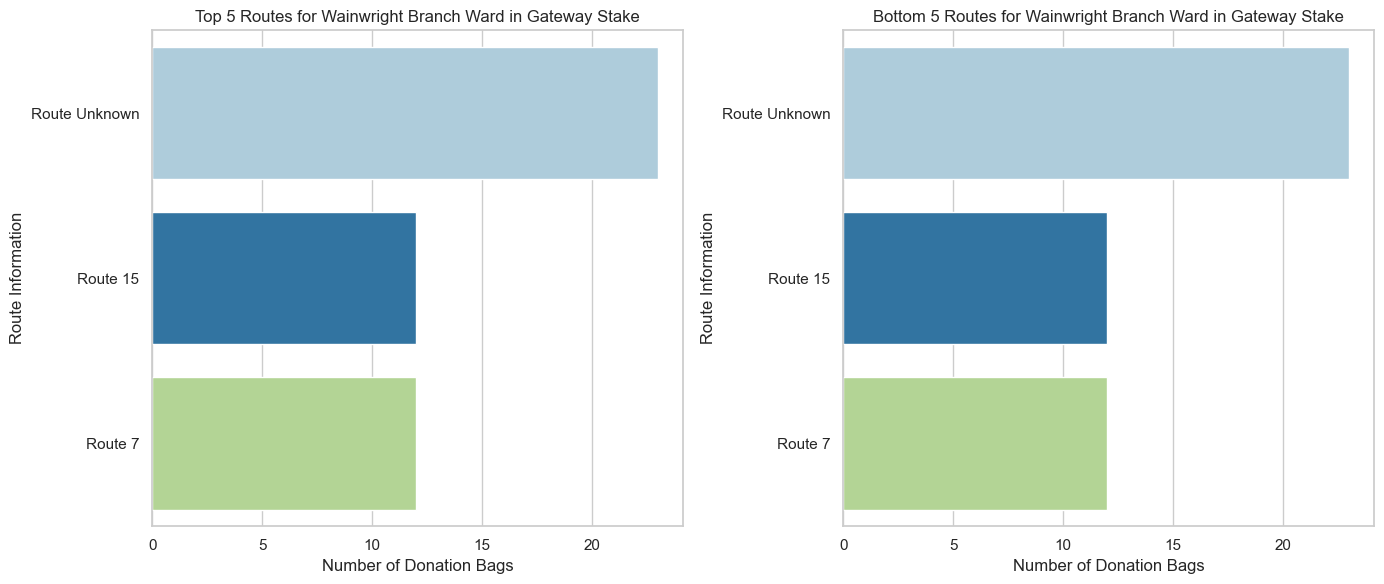

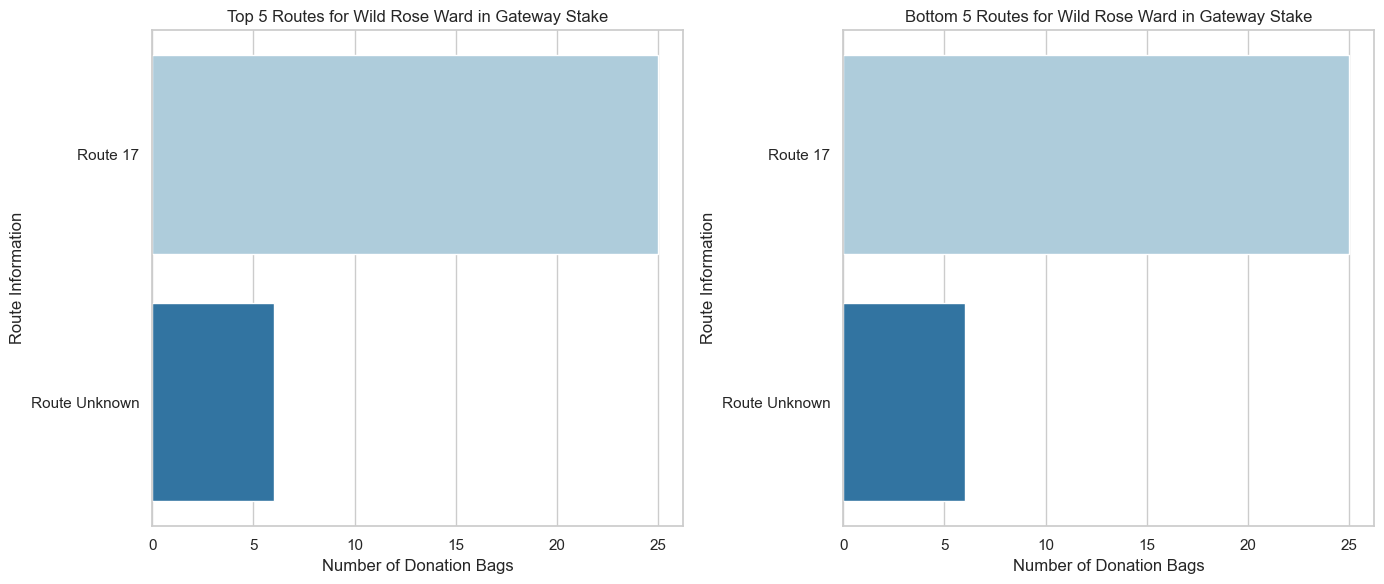

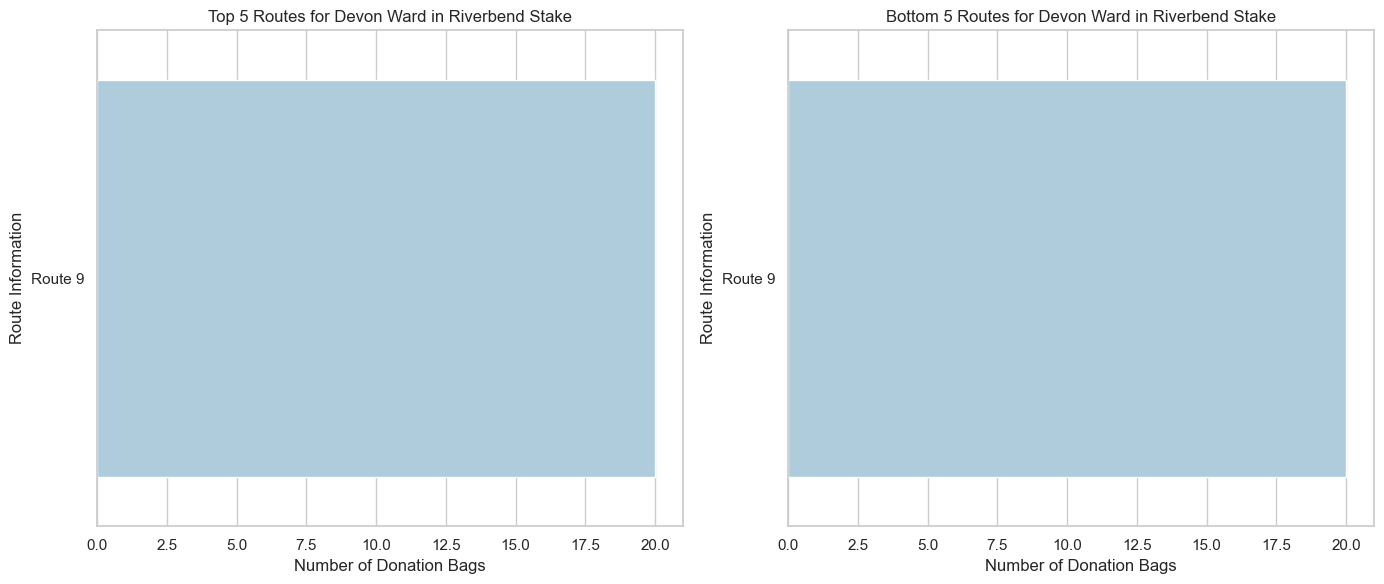

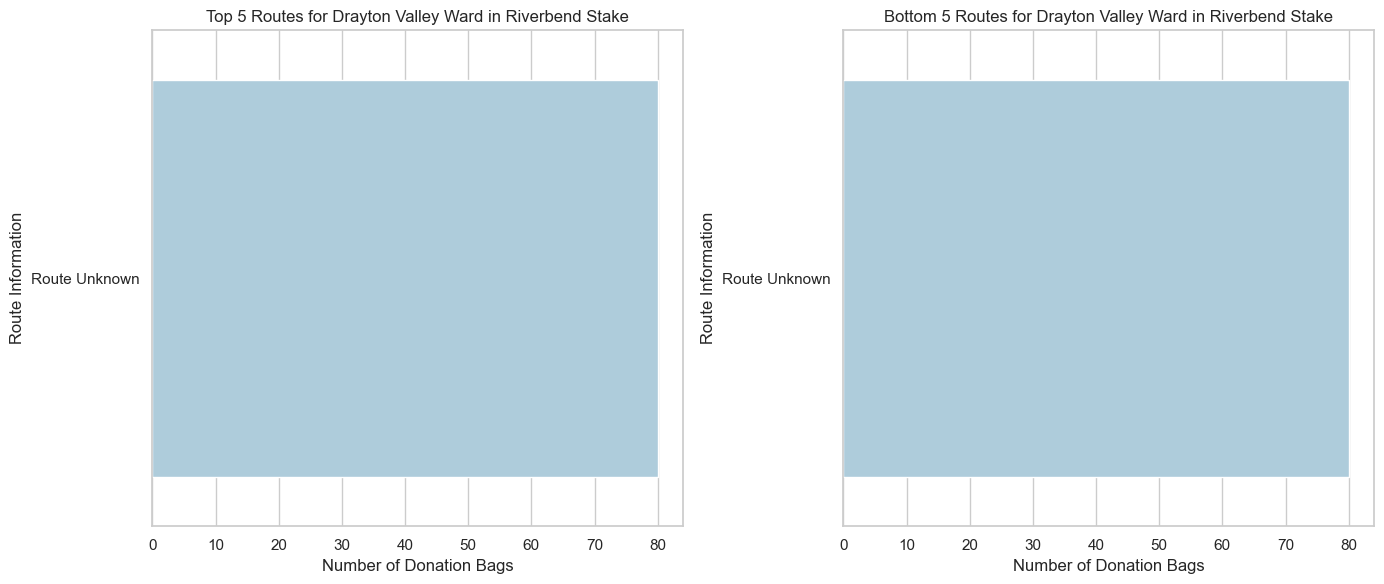

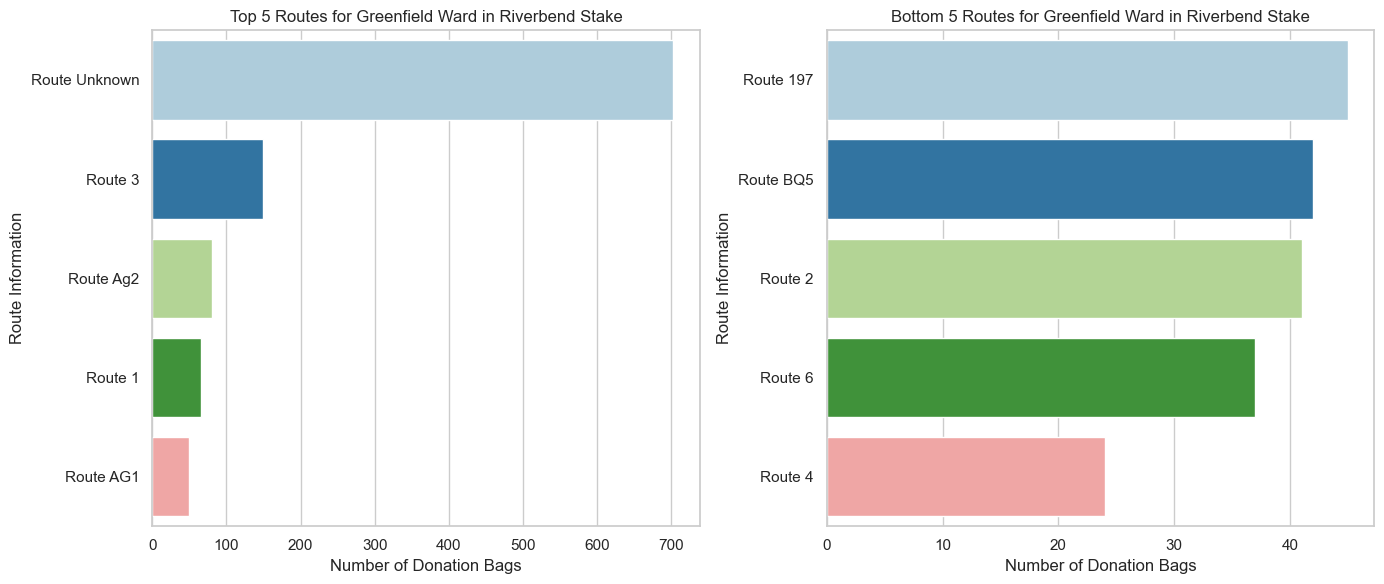

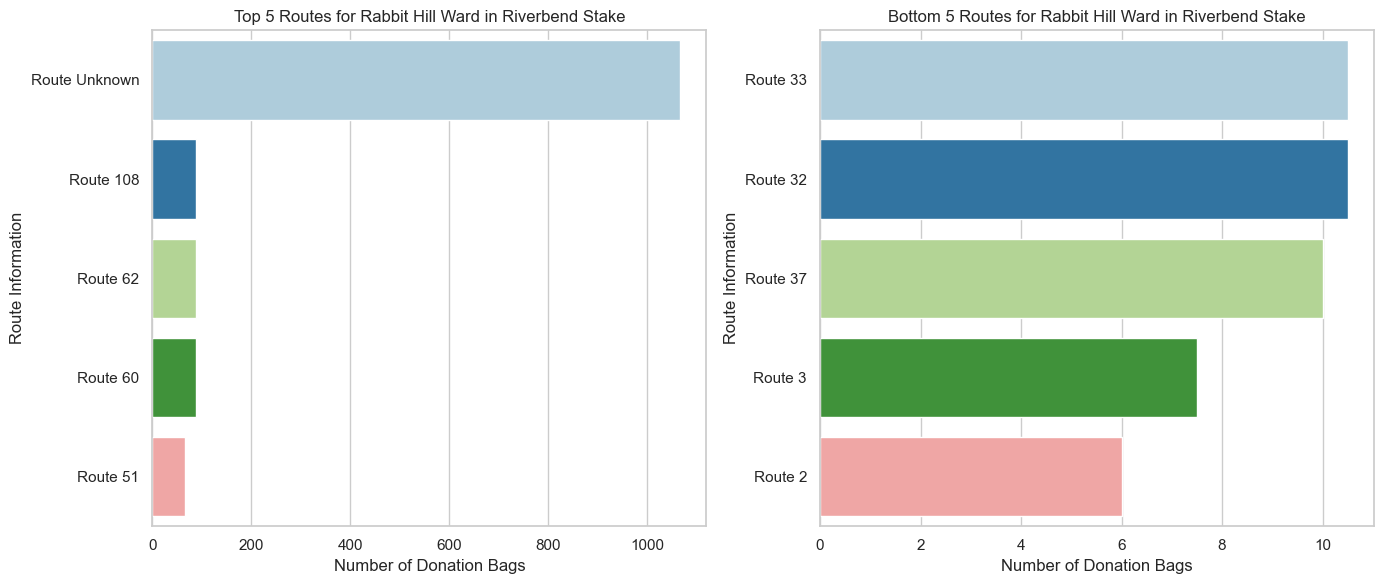

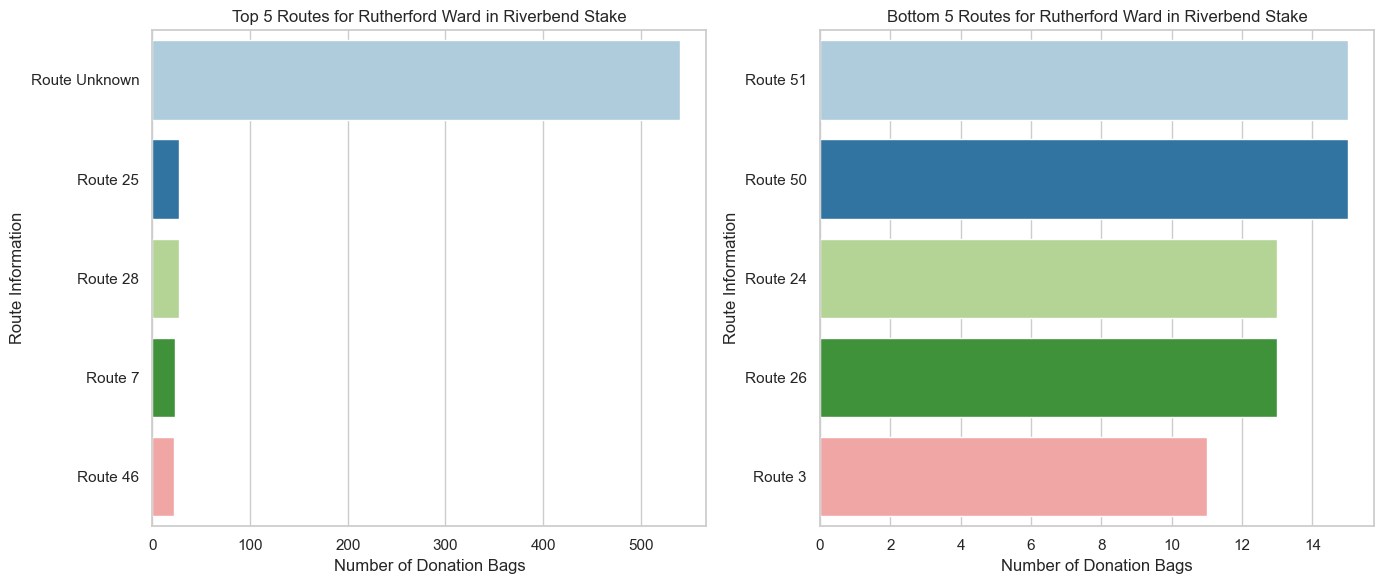

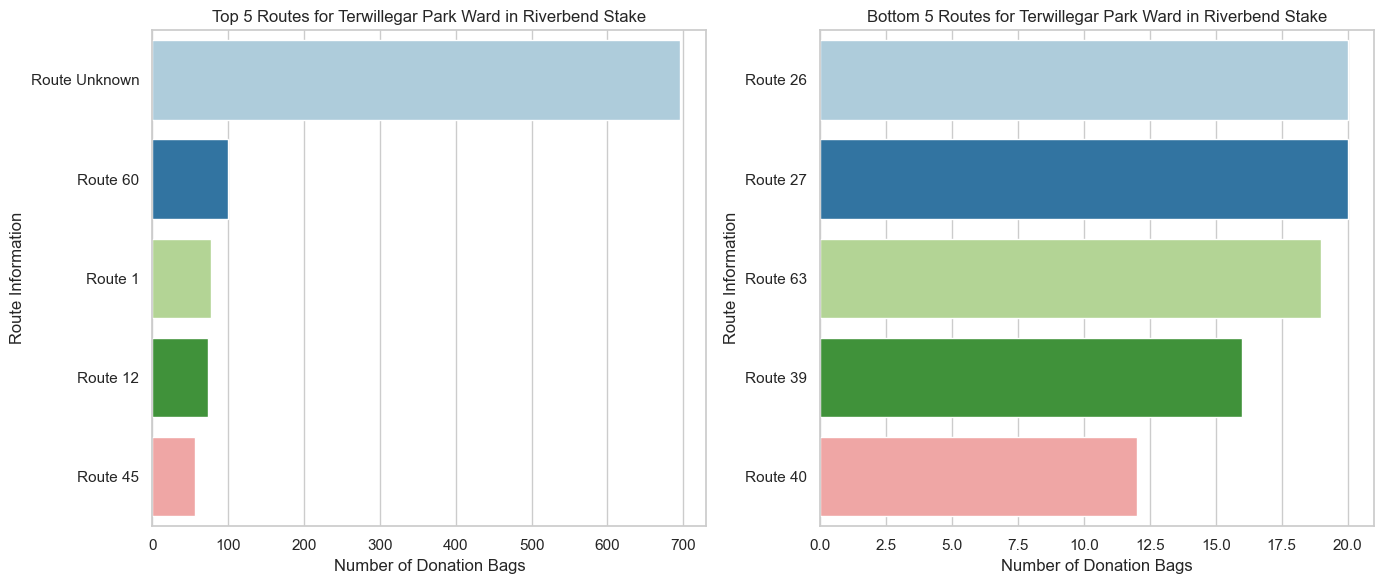

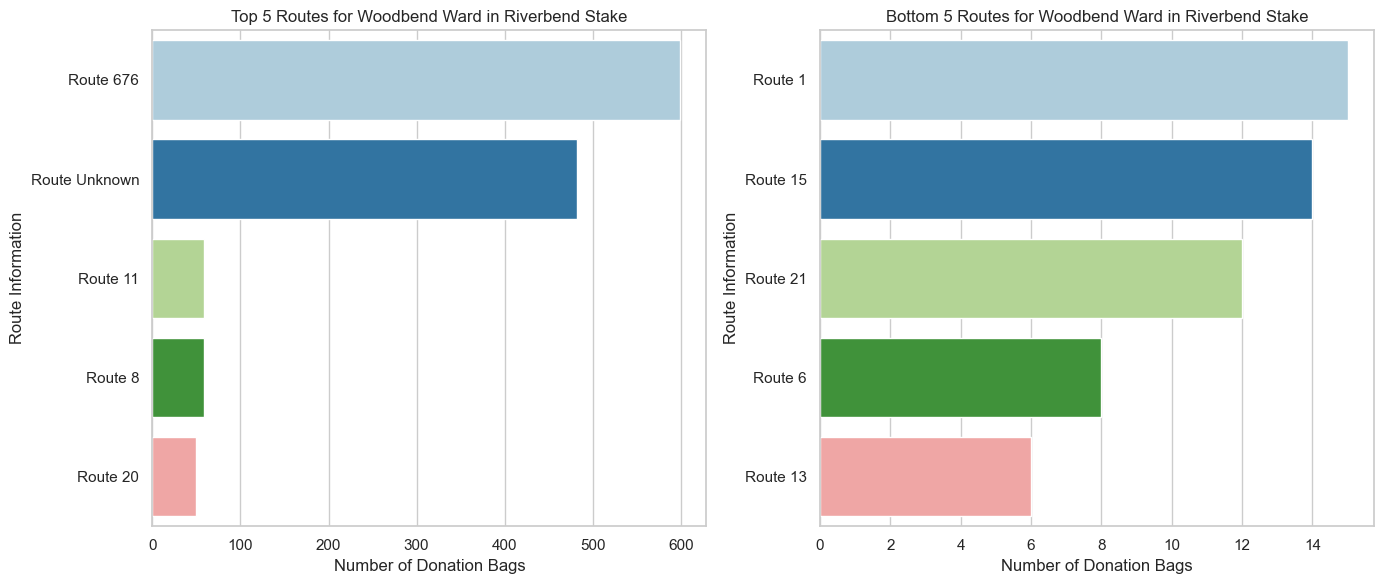

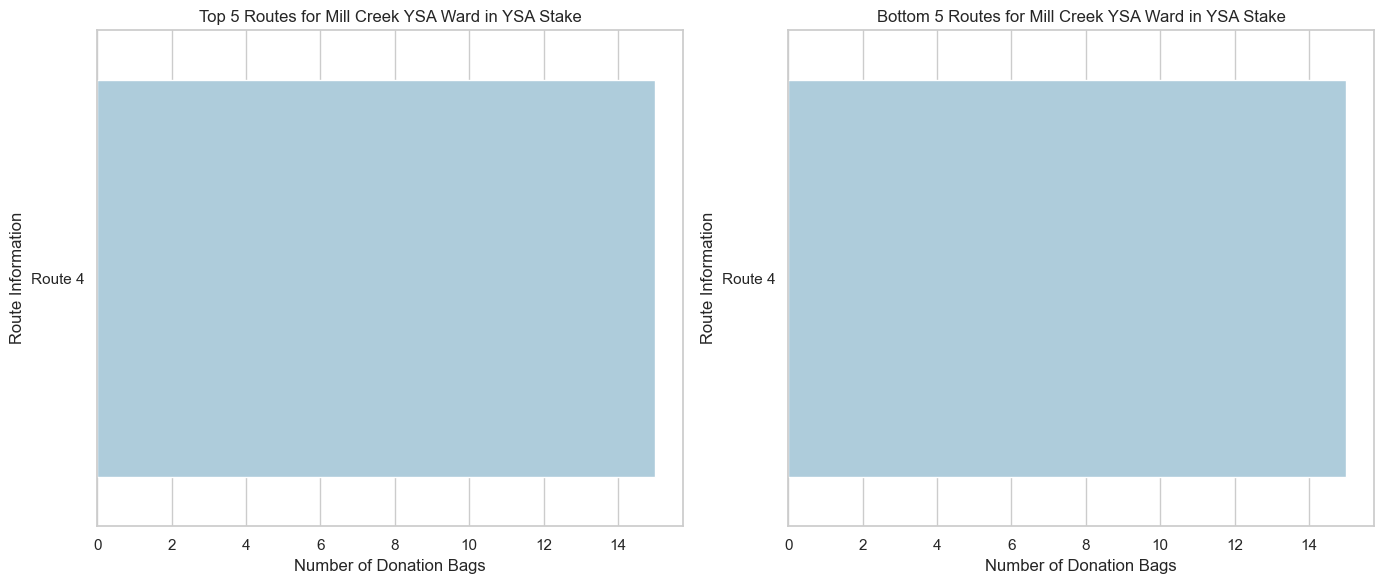

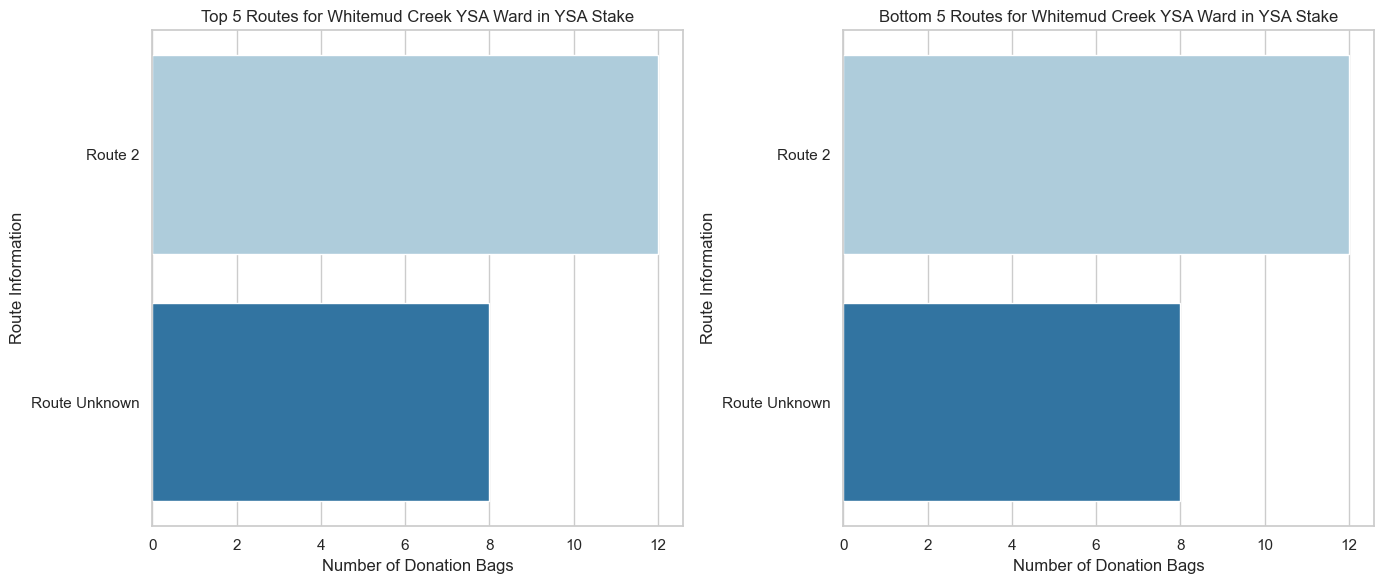

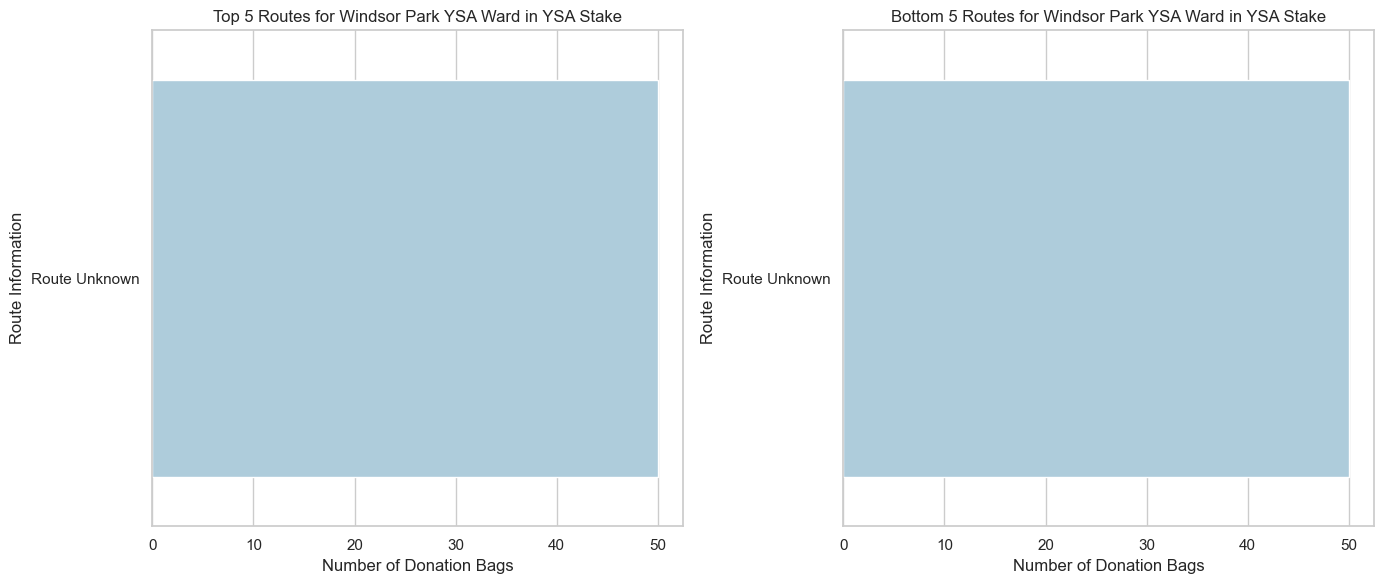

In [41]:
sns.set(style="whitegrid")

for stake, df in stake_dfs.items():
    unique_wards = df['Ward'].unique()

    for ward in unique_wards:
        ward_data = df[df['Ward'] == ward]
        total_bags_per_route = ward_data.groupby('Route Information')['Number of Donation Bags'].sum().reset_index()
        total_bags_per_route_sorted = total_bags_per_route.sort_values(by='Number of Donation Bags', ascending=False).reset_index(drop=True)

        top_5 = total_bags_per_route_sorted.head(5).reset_index(drop=True)
        bottom_5 = total_bags_per_route_sorted.tail(5).reset_index(drop=True)

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

        sns.barplot(x='Number of Donation Bags',
                    y='Route Information',
                    data=top_5,
                    ax=axes[0],
                    palette='Paired',
                    order=top_5['Route Information'])
        axes[0].set_title(f'Top 5 Routes for {ward} in {stake}')
        axes[0].set_xlabel('Number of Donation Bags')
        axes[0].set_ylabel('Route Information')

        sns.barplot(x='Number of Donation Bags',
                    y='Route Information',
                    data=bottom_5,
                    ax=axes[1],
                    palette='Paired',
                    order=bottom_5['Route Information'])
        axes[1].set_title(f'Bottom 5 Routes for {ward} in {stake}')
        axes[1].set_xlabel('Number of Donation Bags')
        axes[1].set_ylabel('Route Information')

        plt.tight_layout()
        plt.show()
